\
\
⚠️ Aby se zamezilo nechtěnému přepsání uložených modelů/parametrů/grafů, jsou v kódu po dotrénování pozměněny všechny `save_path` parametry. Místo `path/to/file.extension` jsou v notebooku aktuálně `path/to/file2.extension`. ⚠️
\
\
\
ℹ️ Trénování probíhalo na následujícím HW: CPU - `Intel Core i5-10400F`, GPU - `NVIDIA GeForce RTX 2070`. Vzhledem k paměťové a časové náročnosti trénování a vyhodnocování některých modelů byly některé hyperparametry omezeny. ℹ️

In [1]:
import os
import re

import pandas as pd
import numpy as np

import multiprocessing as mp

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

import sklearn.metrics as metrics
from sklearn.model_selection import ParameterGrid
from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import pickle
from IPython.display import clear_output

V první fázi se do notebooku nahrají předzpracovaná data (z `analysis.ipynb`) a upraví do vhodných formátů.

In [2]:
Xtrain = pd.read_csv('train_test_data/train.csv', sep=';')
Xval = pd.read_csv('train_test_data/validation.csv', sep=';')

In [3]:
display(Xtrain.head())
print(Xtrain.shape, Xval.shape)

,IP ID,Daily unique domain count,Daily detected query type count,Highest active hour,Lowest active hour,Min hourly query count,Abortion,Alcohol,Anonymisation Services,Architecture / Construction / Furniture,...,Vehicles,Violence / Extreme,Warez / Software Piracy,Weapons / Military,Webmail / Unified Messaging,Web Site Translation,Web Storage,Occurrence of 0 most regularly visited domain,Occurrence of 5 most regularly visited domain,Occurrence of 9 most regularly visited domain
0,1501,783,6,13,2,95,0,0,0,6,...,0,0,0,0,369,0,0,24,21,18
1,1233,36,9,16,3,0,0,0,0,0,...,0,0,0,0,9,0,0,15,1,1
2,2627,10,2,23,0,0,0,0,0,0,...,0,0,0,0,12,0,0,4,1,1
3,3214,890,4,7,17,214,0,0,0,4,...,0,0,0,0,831,0,0,24,24,23
4,2172,761,4,8,21,34,0,0,0,39,...,4,0,0,0,430,0,0,24,7,7


(105777, 80) (23019, 80)


In [4]:
Xtrain = Xtrain.sample(frac=1).reset_index(drop=True)
Xval = Xval.sample(frac=1).reset_index(drop=True)

In [5]:
display(Xtrain.head())
print(Xtrain.shape, Xval.shape)

,IP ID,Daily unique domain count,Daily detected query type count,Highest active hour,Lowest active hour,Min hourly query count,Abortion,Alcohol,Anonymisation Services,Architecture / Construction / Furniture,...,Vehicles,Violence / Extreme,Warez / Software Piracy,Weapons / Military,Webmail / Unified Messaging,Web Site Translation,Web Storage,Occurrence of 0 most regularly visited domain,Occurrence of 5 most regularly visited domain,Occurrence of 9 most regularly visited domain
0,726,1253,7,20,2,47,4,0,0,0,...,0,0,0,0,810,0,2,18,17,17
1,177,303,4,12,20,100,0,0,0,0,...,0,0,0,0,216,0,0,24,5,5
2,2418,195,2,20,8,0,0,0,0,0,...,0,0,0,0,29,0,0,16,5,4
3,2764,507,3,11,0,0,0,0,0,0,...,0,0,0,0,258,0,8,7,6,5
4,2398,1070,5,11,4,737,0,0,0,0,...,0,0,0,0,1426,0,1,24,24,24


(105777, 80) (23019, 80)


In [6]:
Ytrain = Xtrain['IP ID']
Xtrain = Xtrain.drop('IP ID', axis=1)

Yval = Xval['IP ID']
Xval = Xval.drop('IP ID', axis=1)

In [7]:
print(Xtrain.shape, Ytrain.shape)
print(Xval.shape, Yval.shape)

(105777, 79) (105777,)
(23019, 79) (23019,)


In [8]:
min_max_scaler = MinMaxScaler()
Xtrain_minmax = min_max_scaler.fit_transform(Xtrain)
Xval_minmax = min_max_scaler.transform(Xval)

Xtrain_minmax = pd.DataFrame(Xtrain_minmax, columns=Xtrain.columns)
Xval_minmax = pd.DataFrame(Xval_minmax, columns=Xtrain.columns)


standard_scaler = StandardScaler()
Xtrain_standard = standard_scaler.fit_transform(Xtrain)
Xval_standard = standard_scaler.transform(Xval)

Xtrain_standard = pd.DataFrame(Xtrain_standard, columns=Xtrain.columns)
Xval_standard = pd.DataFrame(Xval_standard, columns=Xtrain.columns)


# Pojmenování hlavních komponent
pca_cols = []
for i in range(1,51):
    pca_cols.append(f'Hlavní komponenta {i}')
pca = PCA(n_components=50)
Xtrain_pca = pca.fit_transform(Xtrain_standard)
Xval_pca = pca.transform(Xval_standard)

Xtrain_pca = pd.DataFrame(Xtrain_pca, columns=pca_cols)
Xval_pca = pd.DataFrame(Xval_pca, columns=pca_cols)

Kvůli modelům neuronových sítí a XGBoost je nutné vytvořit alternativní mapovaní `IP ID`, neboli predikované proměnné. Konkrétně mapování od 0 do 1726.

In [9]:
# Mapování jednotlivých IP ID na rozsah 0-1726
# Použito pro neuronové sítě kvůli "loss = loss_fn(outputs, labels)", kde je problém s indexací + pro XGBoost
uniq = sorted(set(Ytrain))
mapping_id_to_int = {}
mapping_int_to_id = {}
Ytrain_from_zero = []
Yval_from_zero = []

for i, elem in enumerate(uniq):
    mapping_int_to_id[i] = elem
    mapping_id_to_int[elem] = i

for idd in Ytrain:
    Ytrain_from_zero.append(mapping_id_to_int[idd])

for idd in Yval:
    Yval_from_zero.append(mapping_id_to_int[idd])

________

Pomocné funkce pro výpis výsledků trénování. Je použit u náhodného lesa, XGBoostu a naivního Bayese.

In [10]:
def print_results(best_model, trainX, trainY, valX, valY, best_params, train_acc, val_acc, model_name, data_type, show=True, save=False, save_path=None):
    Ypred = best_model.predict(trainX)
    Ypred_val = best_model.predict(valX)
    best_vacc = metrics.accuracy_score(valY, Ypred_val)
    print(f'\nNejlepší parametry: {best_params}')
    print(f'\nTrénovací přesnost (accuracy): {metrics.accuracy_score(trainY, Ypred):.5f}')
    print(f'Validační přesnost (accuracy): {best_vacc:.5f}')

    # average="macro" -> Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
    # https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
    # macro zachází se všemi třídami rovnoměrně = v tomto případě jsou třídy (relativně) vyváženě
    # V případě dalšího zkoumání, které může zahrnovat i nevyvážené třídy lze použít average="weighted"
    print(f'\nValidační preciznost (precision): {metrics.precision_score(valY, Ypred_val, average="macro", zero_division=0.0):.3f}')
    print(f'Validační senzitivita (recall): {metrics.recall_score(valY, Ypred_val, average="macro", zero_division=0.0):.3f}')
    print(f'Validační F1 skóre: {metrics.f1_score(valY, Ypred_val, average="macro", zero_division=0.0):.3f}')

    # Zjistit, kolik tříd umí model reálně rozlišit
    unique_predicted = len(np.unique(Ypred))
    print(f'\nModel predikoval {unique_predicted} ({(unique_predicted/1727)*100:.1f} %) unikátních tříd. Neumí predikovat {1727 - unique_predicted} ({((1727 - unique_predicted)/1727)*100:.1f} %) tříd.\n')

    # print(f'Nepredikované třídy (IP ID): {set(trainY) - set(Ypred)}')
    param_set = list(range(len(train_acc)))
    plt.plot(param_set, train_acc, '.-', markersize = 5, label='Trénovací přesnost', color = 'blue')
    plt.plot(param_set, val_acc, '.-', markersize = 5, label='Validační přesnost', color = 'green')
    plt.plot([param_set[np.argmax(val_acc)]], [val_acc[np.argmax(val_acc)]],'x', color = 'red', markersize = 10, label=f'Nejlepší validační přesnost ({best_vacc:.3f})')
    plt.xlabel('Kombinace parametrů')
    plt.ylabel('Přesnost')
    plt.title(f'{model_name}: průběh trénování –⁠⁠⁠⁠⁠⁠ {data_type}')
    plt.ylim(bottom=0, top=1)
    tick=range(len(train_acc))[::2] if len(train_acc) <= 30 else range(len(train_acc))[::4]
    plt.xticks(ticks=tick, labels=[])
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))
    plt.grid(which='major', axis='y', linestyle='--')
    if save and save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)

In [11]:
def print_feature_importance(model, trainX, model_name, data_type, show=True, save=False, save_path=None):
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html -> Feature importance based on mean decrease in impurity (MDI)
    # Použit modelový kód z Kaggle: https://www.kaggle.com/code/prashant111/random-forest-classifier-feature-importance (využití pd.Series)
    feature_scores = pd.Series(model.feature_importances_, index=trainX.columns).sort_values(ascending=True)
    feature_scores.tail(20).plot.barh(figsize=(8,8))
    plt.ylabel('Příznaky')
    plt.xlabel('Skoré důležitosti')
    plt.title(f'Graf vvýznamnosti příznaků modelu {model_name}\n({data_type}, top 20 příznaků)')
    if save and save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)

_____
# 1) Náhodný les

První trénovaný model je náhodný les. Tento model je paměťově nejnáročnější. Výsledné modely mají každý více než 4 GB a samotné trénování je velmi náročné na paměť RAM.

Hyperparametr, který nejvíce ovlivňoval trénování, byla maximalní hloubka rozhodovacích stromů v náhodném lese. V případě, kdy byla vyšší než 10 přestávala stačit výpočetní kapacita paměti RAM. Zároveň to není úplně na škodu, jelikož příliš hluboké stromy by vedly k přeučení modelu. Hloubka nižší než 8 už ale dávala velmi špatné výsledky.

V `param_grid` níže nejsou uvedeny všechny rozsahy hyperparametrů, které byly během trénování zkoušeny (platí i u ostatních modelů). Ponechané hodnoty pokrývaly jednotlivě nejlepší nalezené hyperparametry a kombinují je. (Například Gini index vracel až od třetinu horší výsledky než entropie.)

Časová náročnost byla u trénování náhodného lesa vysoká. I proto nešlo vyzkoušet vše "co by člověk chtěl".

In [12]:
def train_random_forest(trainX, trainY, valX, valY, param_comb):
    best_score = -1
    best_model = None
    best_params = None
    train_acc = []
    val_acc = []
    
    for combination in tqdm(param_comb):
        # print(combination)
        
        clfRF = RandomForestClassifier(**combination)    
        clfRF.fit(trainX, trainY)
    
        y_train_pred = clfRF.predict(trainX)
        y_val_pred = clfRF.predict(valX)
        
        train = metrics.accuracy_score(trainY, y_train_pred)
        val = metrics.accuracy_score(valY, y_val_pred)

        # print(train, val)
        
        val_acc.append(val)
        train_acc.append(train)
        
        if val > best_score:
            best_score = val
            best_model = clfRF
            best_params = combination
    return train_acc, val_acc, best_model, best_params, best_score 

In [13]:
# Zkoušely se různé parametry:
# Estimators -> 30-200; max_samples -> 10 000-MAX; depth -> 7-12; criterion -> 'gini' daválo až o polovinu horší výsledky!
# vztah entropie a log_loss u tohoto modelu - https://stackoverflow.com/questions/78499525/is-there-a-difference-in-the-underlying-sklearn-entropy-and-log-loss-criteri

param_grid = {
    'max_features': ['log2', 'sqrt'],
    'criterion': ['entropy',],
    'n_estimators': [100, 150], # 200 estimators už příliš zvětšuje model, neúnosné i pro paměť lokálního stroje
    'max_samples': range(20000, len(Xtrain), 25000),
    'max_depth': [9, 10],
    'bootstrap': [True],
    'n_jobs': [mp.cpu_count() - mp.cpu_count()//3],
    'class_weight': ['balanced'],
}

param_comb_rf = ParameterGrid(param_grid)
print(len(param_comb_rf))

32


U každého modelu se vždy postupně trénují 4 verze daného modelu:
- na základních datech,
- na normalizovaných datech pomocí min-max,
- na standardizovaných datech,
- na datech transformovaných pomocí PCA.

PCA je zde nejvíce experimentální. Je otázkou, zda zvolená redukce (na 50 hlavních komponent) neuškodila datům příliš. Kdyby ovšem některý z modelů dával na PCA datech dobré výsledky, byl by to bonus, jelikož menší dimenze je pro výpočetní náročnost do budoucna přívětivější.

____
### Model I - základní data

In [14]:
train_acc_rf_classic, val_acc_rf_classic, best_rf_classic, best_params_rf_classic, best_score_rf_classic = train_random_forest(Xtrain, Ytrain, Xval, Yval, param_comb_rf)

100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [56:12<00:00, 105.40s/it]


In [15]:
best_score_rf_classic

0.7271818932186455

In [12]:
# pickle.dump(best_params_rf_classic, open('best_models/random_forest/rf_classic_params2.pkl', 'wb'))
# pickle.dump(best_rf_classic, open('best_models/random_forest/rf_classic2.pkl', 'wb'))
# pickle.dump(val_acc_rf_classic, open('best_models/random_forest/rf_classic_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_rf_classic, open('best_models/random_forest/rf_classic_train_acc2.pkl', 'wb'))

In [12]:
load_rf_classic_params = pickle.load(open('best_models/random_forest/rf_classic_params.pkl', 'rb'))
load_rf_classic = pickle.load(open('best_models/random_forest/rf_classic.pkl', 'rb'))
load_rf_val_acc_classic = pickle.load(open('best_models/random_forest/rf_classic_val_acc.pkl', 'rb'))
load_rf_train_acc_classic = pickle.load(open('best_models/random_forest/rf_classic_train_acc.pkl', 'rb'))


Nejlepší parametry: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_samples': 95000, 'n_estimators': 150, 'n_jobs': 8}

Trénovací přesnost (accuracy): 0.81929
Validační přesnost (accuracy): 0.72718

Validační preciznost (precision): 0.768
Validační senzitivita (recall): 0.726
Validační F1 skóre: 0.718

Model predikoval 1676 (97.0 %) unikátních tříd. Neumí predikovat 51 (3.0 %) tříd.



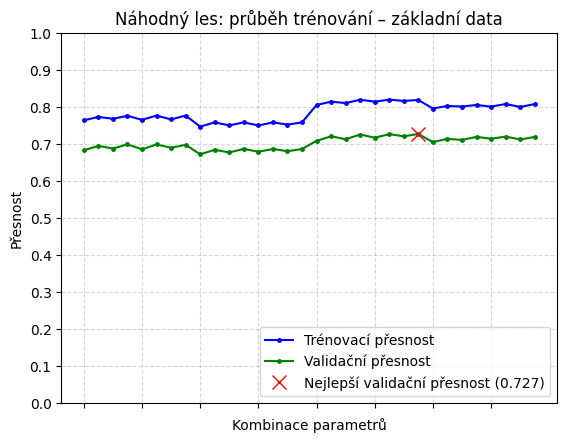

In [13]:
# print_results(best_rf_classic, Xtrain, Ytrain, Xval, Yval, best_params_rf_classic, train_acc_rf_classic, val_acc_rf_classic, 'Náhodný les','základní data', save=True, save_path='images/random_forest/rf_classic2.png')
print_results(load_rf_classic, Xtrain, Ytrain, Xval, Yval, load_rf_classic_params, load_rf_train_acc_classic, load_rf_val_acc_classic, 'Náhodný les', 'základní data', save=False, save_path='images/random_forest/rf_classic2.png')

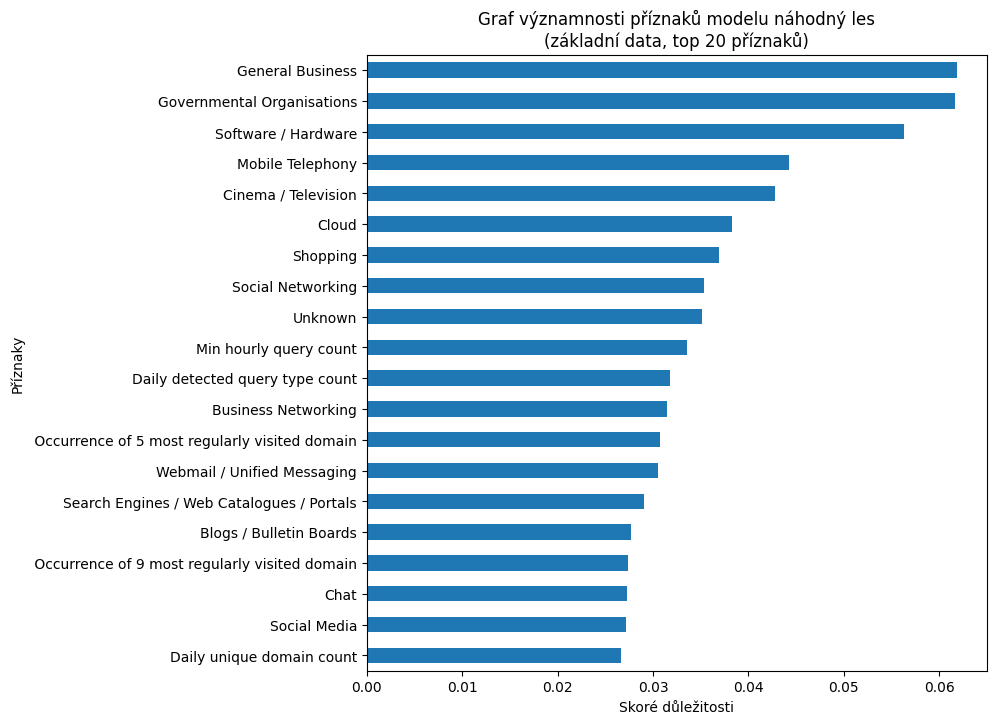

In [14]:
# print_feature_importance(best_rf_classic, Xtrain, 'náhodný les', 'základní data', save=True, save_path='images/random_forest/rf_classic_features2.png')
print_feature_importance(load_rf_classic, Xtrain, 'náhodný les', 'základní data', save=False, save_path='images/random_forest/rf_classic_features2.png')

Úvodní model náhodného lesa je dobrým odrazovým můstkem pro nadcházející trénování. Přesnost přesahující 70 % je při tak velkém počtu klasifikačních tříd dobrým výsledkem.

Významnost jednotlivých příznaků se u náhodného lesa získává ze zabudované funkce `feature_importances_`. Ta určuje důležitost příznaků metodou _MDI_ (Mean Decrease in Impurity). Tato metoda dle názvu hodnotí na základě "snížení nečistoty v datech" (měřeného entropií, nebo Gini indexem) během větvení. Čím více dokáže daný příznak data pročistit, tím větší má _MDI_. 
____
### Model II - minmax

In [14]:
train_acc_rf_minmax, val_acc_rf_minmax, best_rf_minmax, best_params_rf_minmax, best_score_rf_minmax = train_random_forest(Xtrain_minmax, Ytrain, Xval_minmax, Yval, param_comb_rf)

100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [54:19<00:00, 101.87s/it]


In [15]:
best_score_rf_minmax

0.7284417220556931

In [16]:
# pickle.dump(best_params_rf_minmax, open('best_models/random_forest/rf_minmax_params2.pkl', 'wb'))
# pickle.dump(best_rf_minmax, open('best_models/random_forest/rf_minmax2.pkl', 'wb'))
# pickle.dump(val_acc_rf_minmax, open('best_models/random_forest/rf_minmax_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_rf_minmax, open('best_models/random_forest/rf_minmax_train_acc2.pkl', 'wb'))

In [12]:
load_rf_minmax_params = pickle.load(open('best_models/random_forest/rf_minmax_params.pkl', 'rb'))
load_rf_minmax = pickle.load(open('best_models/random_forest/rf_minmax.pkl', 'rb'))
load_rf_val_acc_minmax = pickle.load(open('best_models/random_forest/rf_minmax_val_acc.pkl', 'rb'))
load_rf_train_acc_minmax = pickle.load(open('best_models/random_forest/rf_minmax_train_acc.pkl', 'rb'))


Nejlepší parametry: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_samples': 95000, 'n_estimators': 150, 'n_jobs': 8}

Trénovací přesnost (accuracy): 0.82010
Validační přesnost (accuracy): 0.72844

Validační preciznost (precision): 0.769
Validační senzitivita (recall): 0.727
Validační F1 skóre: 0.719

Model predikoval 1673 (96.9 %) unikátních tříd. Neumí predikovat 54 (3.1 %) tříd.



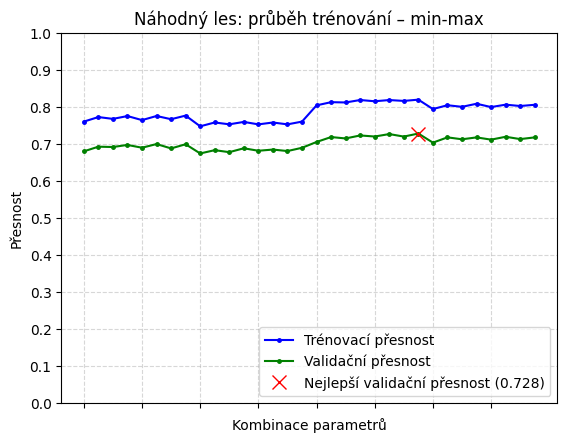

In [13]:
# print_results(best_rf_minmax, Xtrain_minmax, Ytrain, Xval_minmax, Yval, best_params_rf_minmax, train_acc_rf_minmax, val_acc_rf_minmax, 'Náhodný les', 'min-max', save=True, save_path='images/random_forest/rf_minmax2.png')
print_results(load_rf_minmax, Xtrain_minmax, Ytrain, Xval_minmax, Yval, load_rf_minmax_params, load_rf_train_acc_minmax, load_rf_val_acc_minmax, 'Náhodný les', 'min-max', save=False, save_path='images/random_forest/rf_minmax2.png')

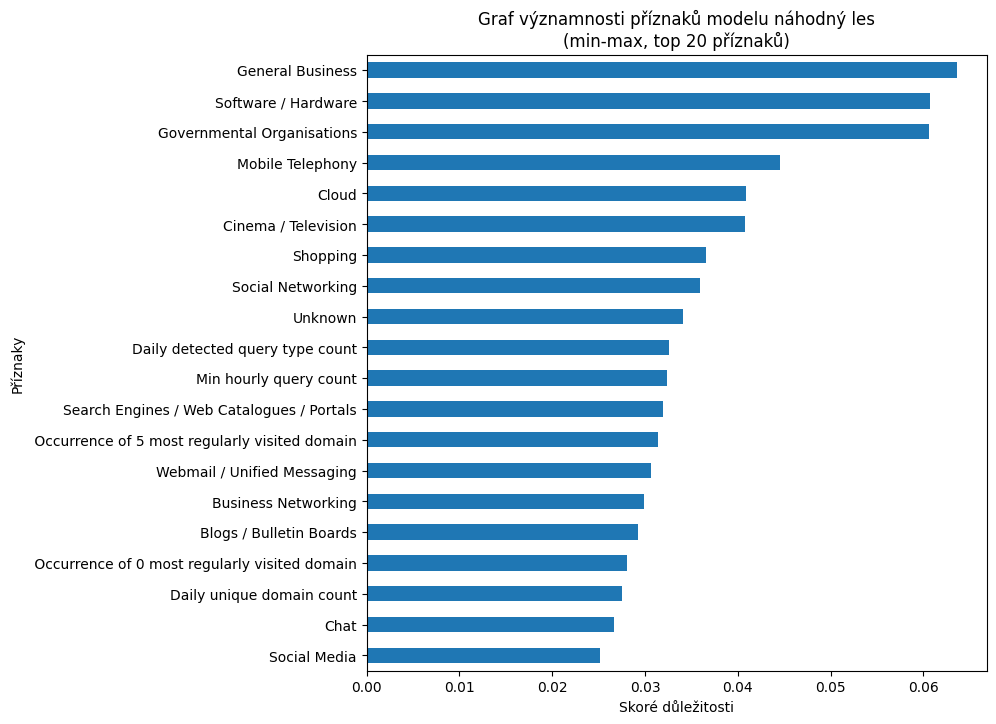

In [14]:
# print_feature_importance(best_rf_minmax, Xtrain_minmax, 'náhodný les', 'min-max', save=True, save_path='images/random_forest/rf_minmax_features2.png')
print_feature_importance(load_rf_minmax, Xtrain_minmax, 'náhodný les', 'min-max', save=True, save_path='images/random_forest/rf_minmax_features2.png')

____
### Model III - standardizace

In [14]:
train_acc_rf_standard, val_acc_rf_standard, best_rf_standard, best_params_rf_standard, best_score_rf_standard = train_random_forest(Xtrain_standard, Ytrain, Xval_standard, Yval, param_comb_rf)

100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [58:55<00:00, 110.49s/it]


In [15]:
best_score_rf_standard

0.728572049176767

In [16]:
# pickle.dump(best_params_rf_standard, open('best_models/random_forest/rf_standard_params2.pkl', 'wb'))
# pickle.dump(best_rf_standard, open('best_models/random_forest/rf_standard2.pkl', 'wb'))
# pickle.dump(val_acc_rf_standard, open('best_models/random_forest/rf_standard_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_rf_standard, open('best_models/random_forest/rf_standard_train_acc2.pkl', 'wb'))

In [12]:
load_rf_standard_params = pickle.load(open('best_models/random_forest/rf_standard_params.pkl', 'rb'))
load_rf_standard = pickle.load(open('best_models/random_forest/rf_standard.pkl', 'rb'))
load_rf_val_acc_standard = pickle.load(open('best_models/random_forest/rf_standard_val_acc.pkl', 'rb'))
load_rf_train_acc_standard = pickle.load(open('best_models/random_forest/rf_standard_train_acc.pkl', 'rb'))


Nejlepší parametry: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_samples': 95000, 'n_estimators': 150, 'n_jobs': 8}

Trénovací přesnost (accuracy): 0.82179
Validační přesnost (accuracy): 0.72857

Validační preciznost (precision): 0.768
Validační senzitivita (recall): 0.727
Validační F1 skóre: 0.720

Model predikoval 1686 (97.6 %) unikátních tříd. Neumí predikovat 41 (2.4 %) tříd.



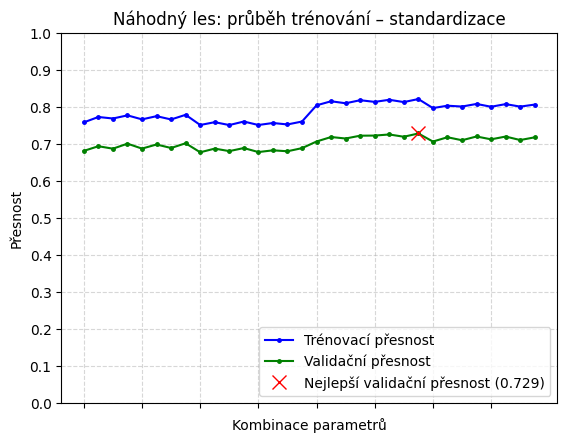

In [13]:
# print_results(best_rf_standard, Xtrain_standard, Ytrain, Xval_standard, Yval, best_params_rf_standard, train_acc_rf_standard, val_acc_rf_standard, 'Náhodný les', 'standardizace', save=True, save_path='images/random_forest/rf_standard2.png')
print_results(load_rf_standard, Xtrain_standard, Ytrain, Xval_standard, Yval, load_rf_standard_params, load_rf_train_acc_standard, load_rf_val_acc_standard, 'Náhodný les', 'standardizace', save=False, save_path='images/random_forest/rf_standard2.png')

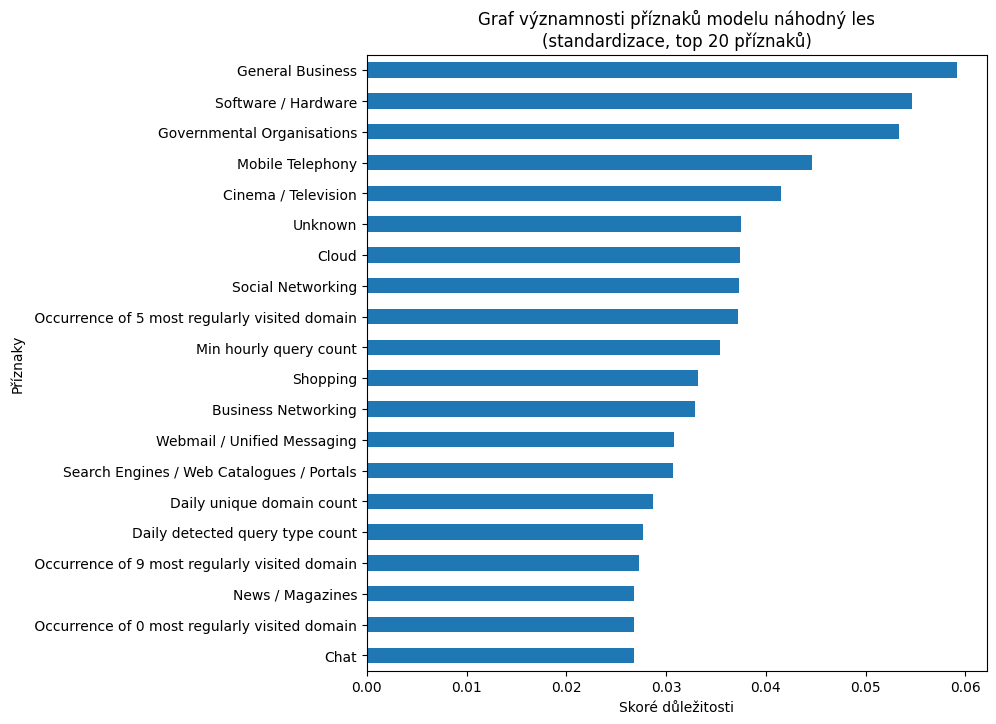

In [14]:
# print_feature_importance(best_rf_standard, Xtrain_standard, 'náhodný les', 'standardizace', save=True, save_path='images/random_forest/rf_standard_features2.png')
print_feature_importance(load_rf_standard, Xtrain_standard, 'náhodný les', 'standardizace', save=False, save_path='images/random_forest/rf_standard_features2.png')

____
### Model IV - PCA

In [15]:
param_grid_pca = {
    'max_features': ['log2'],
    'criterion': ['entropy',],
    'n_estimators': [100, 150], # 200 estimators už příliš zvětšuje model, neúnosné i pro paměť lokálního stroje
    'max_samples': range(70000, len(Xtrain), 25000),
    'max_depth': [9, 10],
    'bootstrap': [True],
    'n_jobs': [mp.cpu_count() - mp.cpu_count()//3],
    'class_weight': ['balanced'],
}

param_comb_rf_pca = ParameterGrid(param_grid_pca)
print(len(param_comb_rf_pca))

8


In [18]:
train_acc_rf_pca, val_acc_rf_pca, best_rf_pca, best_params_rf_pca, best_score_rf_pca = train_random_forest(Xtrain_pca, Ytrain, Xval_pca, Yval, param_comb_rf_pca)

100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [1:41:57<00:00, 764.73s/it]


In [17]:
best_score_rf_pca

0.4300360571701638

In [19]:
# pickle.dump(best_params_rf_pca, open('best_models/random_forest/rf_pca_params2.pkl', 'wb'))
# pickle.dump(best_rf_pca, open('best_models/random_forest/rf_pca2.pkl', 'wb'))
# pickle.dump(val_acc_rf_pca, open('best_models/random_forest/rf_pca_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_rf_pca, open('best_models/random_forest/rf_pca_train_acc2.pkl', 'wb'))

In [13]:
load_rf_pca_params = pickle.load(open('best_models/random_forest/rf_pca_params.pkl', 'rb'))
load_rf_pca = pickle.load(open('best_models/random_forest/rf_pca.pkl', 'rb'))
load_rf_val_acc_pca = pickle.load(open('best_models/random_forest/rf_pca_val_acc.pkl', 'rb'))
load_rf_train_acc_pca = pickle.load(open('best_models/random_forest/rf_pca_train_acc.pkl', 'rb'))


Nejlepší parametry: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_samples': 95000, 'n_estimators': 150, 'n_jobs': 8}

Trénovací přesnost (accuracy): 0.62252
Validační přesnost (accuracy): 0.43234

Validační preciznost (precision): 0.487
Validační senzitivita (recall): 0.431
Validační F1 skóre: 0.399

Model predikoval 1702 (98.6 %) unikátních tříd. Neumí predikovat 25 (1.4 %) tříd.



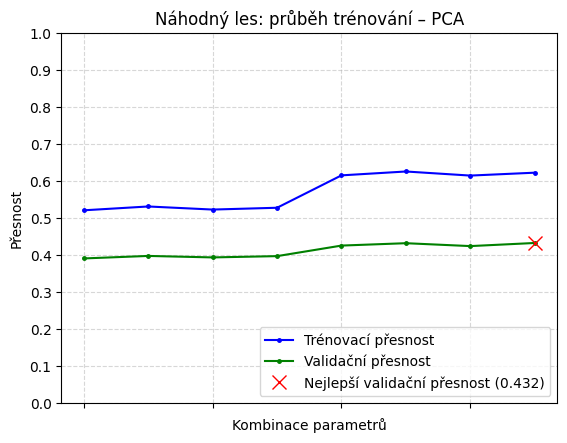

In [36]:
# print_results(best_rf_pca, Xtrain_pca, Ytrain, Xval_pca, Yval, best_params_rf_pca, train_acc_rf_pca, val_acc_rf_pca, 'Náhodný les', 'PCA', save=True, save_path='images/random_forest/rf_pca2.png')
print_results(load_rf_pca, Xtrain_pca, Ytrain, Xval_pca, Yval, load_rf_pca_params, load_rf_train_acc_pca, load_rf_val_acc_pca, 'Náhodný les', 'PCA', save=False, save_path='images/random_forest/rf_pca2.png')

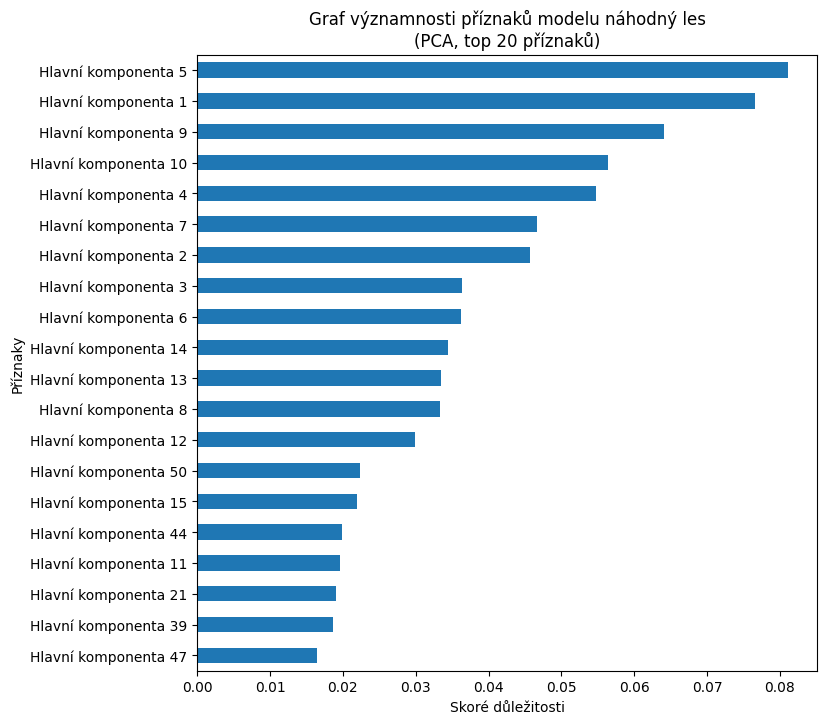

In [28]:
# print_feature_importance(best_rf_pca, Xtrain_pca, 'náhodný les', 'PCA', save=True, save_path='images/random_forest/rf_pca_features2.png')
print_feature_importance(load_rf_pca, Xtrain_pca, 'náhodný les', 'PCA', save=False, save_path='images/random_forest/rf_pca_features2.png')

Z trénování lze vidět, že náhodný les preferuje a považuje za důležité příznaky, které jsou v datech nejpočetněji zastoupeny (viz `analysis.ipynb`). Zároveň, mimo PCA mají všechny modely téměř identickou strukturu a hlavně výsledky. To z důvodu, že stromové modely obecně ve vrcholech fungují principem rozdělování dat na základě prahové hodnoty jednoho konkrétního příznaku. Normalizace pouze data přeškáluje, a proto se tento práh pouze posune na jinou hodnotu, ale data rozdělí stále stejným způsobem. Nicméně standardizace v tomto případě získala 0,2 % lepší výsledek, než základní data. Výsledný model je tak zatím náhodný les + standardizace. PCA v tomto případě naprosto selhalo a náhodný les s upravenými daty v nové bázi nedokázal pracovat.

Důležité je také zmínit časti, kde se ukazuje celkový počet predikovaných tříd, neboli kolik tříd se naučil model predikovat. Vzhledem k rozsáhlosti této úlohy, kdy je 97-98 % všech tříd rozpoznáno, to lze hodnotit pozitivně. Někteří uživatelé se totiž mohou chovat tak podobně, že je některé modely nedokážou od sebe rozlišit.

### Samotný rozhodovací strom pro porovnání

Pro ukázku síly jak náhodného lesa, tak následně XGBoostu je zde jako vsuvka ukázan jednoduchý model rozhodovacího stromu. Jeho výkonnost je následující:

In [26]:
clf_test = DecisionTreeClassifier(max_depth=25, criterion='entropy', max_features='log2', class_weight='balanced')
clf_test.fit(Xtrain, Ytrain)
print(f'Trénovací přesnost rozhodovacího stromu: {metrics.accuracy_score(Ytrain, clf_test.predict(Xtrain)):.5f}')
print(f'Validační přesnost rozhodovacího stromu: {metrics.accuracy_score(Yval, clf_test.predict(Xval)):.5f}')

Trénovací přesnost rozhodovacího stromu: 0.95232
Validační přesnost rozhodovacího stromu: 0.39732


Trénovací přesnost je (podobně jako u XGBoostu níže) velmi vysoká. Ale validační je v porovnání naprosto nepoužitelná. Model je očividně přeučený a neumí generalizovat svoji predikci. Nejedná se tedy o kvalitní model.

Jak náhodný les, tak XGboost proti jednomu stromu dobře generalizují. V tom je hlavní síla obou přístupů - _baggingu_ i _boostingu_.

____
# 2) XGBoost

Tento model pro predikci využívá metod gradientního boostingu a v jednotlivých stromech pracuje s rezidui predikcí místo samotných záznamů.

Implementačně se jedná o specializovanou knihovnu `xgboost`. Umožňuje pro trénink použít GPU, což je velmi přínosné, avšak v tomto případě - klasifikace 1727 tříd - je výpočetní doba stále velmi velká, dokonce největší ze všech použitých modelů. I z toho důvodu nešlo vyzkoušet takový počet hyperparametrů, koli by človek rád.

Opět je zde klíčová maximální hloubka jednoho stromu v celkovém modelu. Jelikož je trénování velice pomalé, maximální vyzkoušená hloubka byla rovna 5. Překvapivě ovšem nepřinesla žádné zlepšení oproti finálně použité hodnotě, tedz 4.

Lehké zlepšení výsledků přinesla i L2 regularizace (hyperparametr `lamba`).

In [12]:
def train_xgb(trainX, trainY, valX, valY, param_comb):
    best_score = -1
    best_model = None
    best_params = None
    train_acc = []
    val_acc = []
    
    for combination in tqdm(param_comb):
        # print(combination)
        clfXGB = xgb.XGBClassifier(**combination)
        clfXGB.fit(trainX, trainY)

        device_param = {'device':'cpu'}
        clfXGB.set_params(**device_param);
        
        y_train_pred = clfXGB.predict(trainX)
        y_val_pred = clfXGB.predict(valX)
        
        train = metrics.accuracy_score(trainY, y_train_pred)
        val = metrics.accuracy_score(valY, y_val_pred)

        # print(train, val)
        
        train_acc.append(train)
        val_acc.append(val)
        
        if val > best_score:
            best_score = val
            best_model = clfXGB
            best_params = combination
    return train_acc, val_acc, best_model, best_params, best_score

In [15]:
def print_feature_importance_xgb(model, trainX, model_name, data_type, show=True, save=False, save_path=None):
    # print(trainX)
    feature_scores = pd.Series(model.get_booster().get_score(importance_type='gain'), index=trainX.columns).sort_values(ascending=True)
    # print(feature_scores)
    unused = []
    for i in range(len(feature_scores)):
        if np.isnan(feature_scores.iloc[i]):
            feature_scores.iloc[i] = 0
            unused.append(feature_scores.index[i])
    print(f'Nepoužité příznaky v predikci: {unused}')
    feature_scores = feature_scores.sort_values()
    feature_scores = feature_scores / feature_scores.sum()
    feature_scores.tail(20).plot.barh(figsize=(8,8))
    plt.ylabel('Příznaky')
    plt.xlabel('Skoré důležitosti')
    plt.title(f'Graf významnosti příznaků modelu {model_name}\n({data_type}, top 20 příznaků)')
    if save and save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)

In [14]:
param_grid_xgb = {
        'objective':['multi:softmax'],
        'n_estimators': [200],
        'max_depth': [4],
        'num_class':[1727],
        'lambda':[0, 1, 2],
        'eval_metric': ['mlogloss'], #cross entropy loss
        'learning_rate': [0.1, 0.2], #eta
        'min_child_weight': [1, 1.5], 
        'device': ['cuda']
}
param_combs_xgb = ParameterGrid(param_grid_xgb)
print(len(param_combs_xgb))

12


___
### Model I - základní data

In [14]:
train_acc_xgb_classic, val_acc_xgb_classic, best_xgb_classic, best_params_xgb_classic, best_score_xgb_classic = train_xgb(Xtrain, Ytrain_from_zero, Xval, Yval_from_zero, param_combs_xgb)

100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [2:12:58<00:00, 664.85s/it]


In [15]:
best_score_xgb_classic

0.8141535253486251

In [16]:
# pickle.dump(best_params_xgb_classic, open('best_models/xgboost/xgb_classic_params2.pkl', 'wb'))
# pickle.dump(best_xgb_classic, open('best_models/xgboost/xgb_classic2.pkl', 'wb'))
# pickle.dump(val_acc_xgb_classic, open('best_models/xgboost/xgb_classic_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_xgb_classic, open('best_models/xgboost/xgb_classic_train_acc2.pkl', 'wb'))

In [12]:
load_xgb_classic_params = pickle.load(open('best_models/xgboost/xgb_classic_params.pkl', 'rb'))
load_xgb_classic = pickle.load(open('best_models/xgboost/xgb_classic.pkl', 'rb'))
load_xgb_val_acc_classic = pickle.load(open('best_models/xgboost/xgb_classic_val_acc.pkl', 'rb'))
load_xgb_train_acc_classic = pickle.load(open('best_models/xgboost/xgb_classic_train_acc.pkl', 'rb'))


Nejlepší parametry: {'device': 'cuda', 'eval_metric': 'mlogloss', 'lambda': 2, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 200, 'num_class': 1727, 'objective': 'multi:softmax'}

Trénovací přesnost (accuracy): 0.94526
Validační přesnost (accuracy): 0.81415

Validační preciznost (precision): 0.821
Validační senzitivita (recall): 0.812
Validační F1 skóre: 0.813

Model predikoval 1712 (99.1 %) unikátních tříd. Neumí predikovat 15 (0.9 %) tříd.



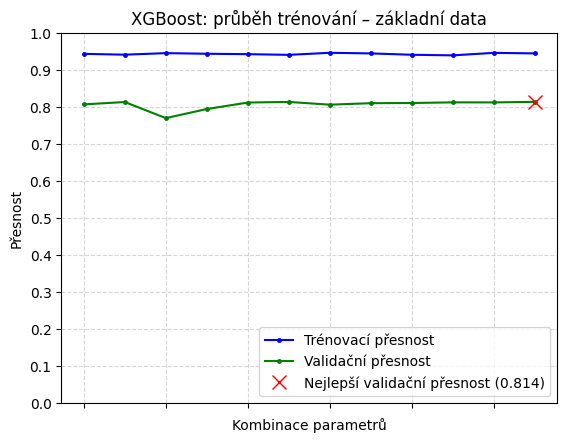

In [13]:
# print_results(best_xgb_classic, Xtrain, Ytrain_from_zero, Xval, Yval_from_zero, best_params_xgb_classic, train_acc_xgb_classic, val_acc_xgb_classic, 'XGBoost', 'základní data', save=True, save_path='images/xgboost/xgb_classic2.png')
print_results(load_xgb_classic, Xtrain, Ytrain_from_zero, Xval, Yval_from_zero, load_xgb_classic_params, load_xgb_train_acc_classic, load_xgb_val_acc_classic, 'XGBoost', 'základní data', save=False, save_path='images/xgboost/xgb_classic2.png')

Nepoužité příznaky v predikci: ['Early Warning', 'Malware', 'Political Extreme / Hate / Discrimination']


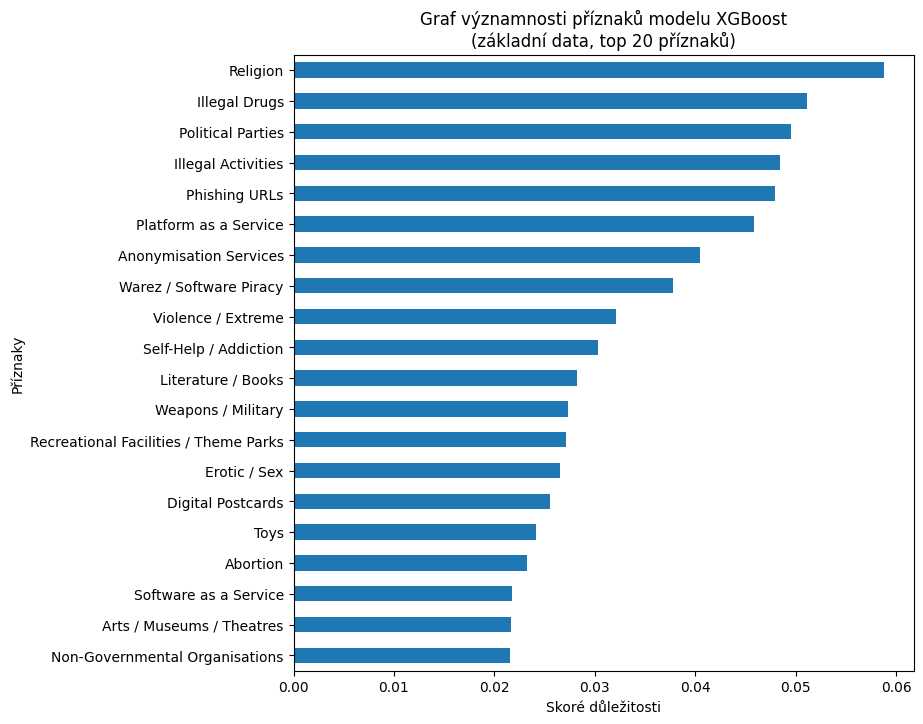

In [16]:
# print_feature_importance_xgb(best_xgb_classic, Xtrain, 'XGBoost', 'základní data', save=True, save_path='images/xgboost/xgb_classic_features2.png')
print_feature_importance_xgb(load_xgb_classic, Xtrain, 'XGBoost', 'základní data', save=False, save_path='images/xgboost/xgb_classic_features2.png')

Důležitost příznaků se v případě tohoto modelu počíta jiným způsobem, než u náhodného lesa. Konkrétně je použita metoda počítající "gain", který vyjadřuje průměrné zlepšení ztrátové funkce na základě rozdělení dat podle daného příznaku.

XGBoost se viditelně zaměřuje na ty doménové katerogie (příznaky), které nejsou v chování uživatelů až tak běžné. Jde tak o opačný přístup, než který aplikoval náhodný les. Poměřování dvou rozdílných metrik je ale nutné brát s rezervou.

___
### Model II - minmax

In [15]:
train_acc_xgb_minmax, val_acc_xgb_minmax, best_xgb_minmax, best_params_xgb_minmax, best_score_xgb_minmax = train_xgb(Xtrain_minmax, Ytrain_from_zero, Xval_minmax, Yval_from_zero, param_combs_xgb)

100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [2:13:41<00:00, 668.42s/it]


In [16]:
best_score_xgb_minmax

0.8148051609539946

In [17]:
# pickle.dump(best_params_xgb_minmax, open('best_models/xgboost/xgb_minmax_params2.pkl', 'wb'))
# pickle.dump(best_xgb_minmax, open('best_models/xgboost/xgb_minmax2.pkl', 'wb'))
# pickle.dump(val_acc_xgb_minmax, open('best_models/xgboost/xgb_minmax_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_xgb_minmax, open('best_models/xgboost/xgb_minmax_train_acc2.pkl', 'wb'))

In [17]:
load_xgb_minmax_params = pickle.load(open('best_models/xgboost/xgb_minmax_params.pkl', 'rb'))
load_xgb_minmax = pickle.load(open('best_models/xgboost/xgb_minmax.pkl', 'rb'))
load_xgb_val_acc_minmax = pickle.load(open('best_models/xgboost/xgb_minmax_val_acc.pkl', 'rb'))
load_xgb_train_acc_minmax = pickle.load(open('best_models/xgboost/xgb_minmax_train_acc.pkl', 'rb'))


Nejlepší parametry: {'device': 'cuda', 'eval_metric': 'mlogloss', 'lambda': 2, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 200, 'num_class': 1727, 'objective': 'multi:softmax'}

Trénovací přesnost (accuracy): 0.94521
Validační přesnost (accuracy): 0.81481

Validační preciznost (precision): 0.821
Validační senzitivita (recall): 0.813
Validační F1 skóre: 0.813

Model predikoval 1715 (99.3 %) unikátních tříd. Neumí predikovat 12 (0.7 %) tříd.



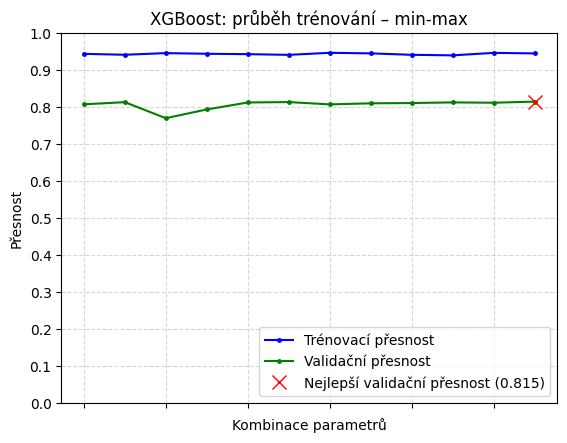

In [18]:
# print_results(best_xgb_minmax, Xtrain_minmax, Ytrain_from_zero, Xval_minmax, Yval_from_zero, best_params_xgb_minmax, train_acc_xgb_minmax, val_acc_xgb_minmax, 'XGBoost', 'min-max', save=True, save_path='images/xgboost/xgb_minmax2.png')
print_results(load_xgb_minmax, Xtrain_minmax, Ytrain_from_zero, Xval_minmax, Yval_from_zero, load_xgb_minmax_params, load_xgb_train_acc_minmax, load_xgb_val_acc_minmax, 'XGBoost', 'min-max', save=False, save_path='images/xgboost/xgb_minmax2.png')

Nepoužité příznaky v predikci: ['Early Warning', 'Malware', 'Political Extreme / Hate / Discrimination']


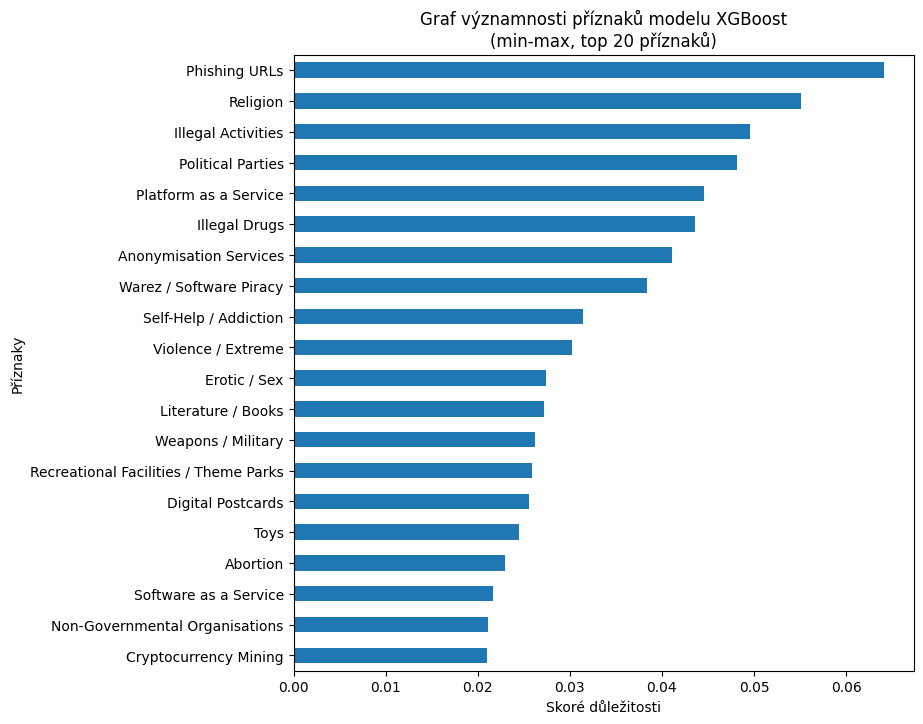

In [19]:
# print_feature_importance_xgb(best_xgb_minmax, Xtrain_minmax, 'XGBoost', 'min-max', save=True, save_path='images/xgboost/xgb_minmax_features2.png')
print_feature_importance_xgb(load_xgb_minmax, Xtrain_minmax, 'XGBoost', 'min-max', save=False, save_path='images/xgboost/xgb_minmax_features2.png')

___
### Model III - standardizace

In [15]:
train_acc_xgb_standard, val_acc_xgb_standard, best_xgb_standard, best_params_xgb_standard, best_score_xgb_standard = train_xgb(Xtrain_standard, Ytrain_from_zero, Xval_standard, Yval_from_zero, param_combs_xgb)

100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [2:21:40<00:00, 708.41s/it]


In [16]:
best_score_xgb_standard

0.8149354880750684

In [17]:
# pickle.dump(best_params_xgb_standard, open('best_models/xgboost/xgb_standard_params2.pkl', 'wb'))
# pickle.dump(best_xgb_standard, open('best_models/xgboost/xgb_standard2.pkl', 'wb'))
# pickle.dump(val_acc_xgb_standard, open('best_models/xgboost/xgb_standard_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_xgb_standard, open('best_models/xgboost/xgb_standard_train_acc2.pkl', 'wb'))

In [20]:
load_xgb_standard_params = pickle.load(open('best_models/xgboost/xgb_standard_params.pkl', 'rb'))
load_xgb_standard = pickle.load(open('best_models/xgboost/xgb_standard.pkl', 'rb'))
load_xgb_val_acc_standard = pickle.load(open('best_models/xgboost/xgb_standard_val_acc.pkl', 'rb'))
load_xgb_train_acc_standard = pickle.load(open('best_models/xgboost/xgb_standard_train_acc.pkl', 'rb'))


Nejlepší parametry: {'device': 'cuda', 'eval_metric': 'mlogloss', 'lambda': 2, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 200, 'num_class': 1727, 'objective': 'multi:softmax'}

Trénovací přesnost (accuracy): 0.94531
Validační přesnost (accuracy): 0.81494

Validační preciznost (precision): 0.822
Validační senzitivita (recall): 0.813
Validační F1 skóre: 0.813

Model predikoval 1710 (99.0 %) unikátních tříd. Neumí predikovat 17 (1.0 %) tříd.



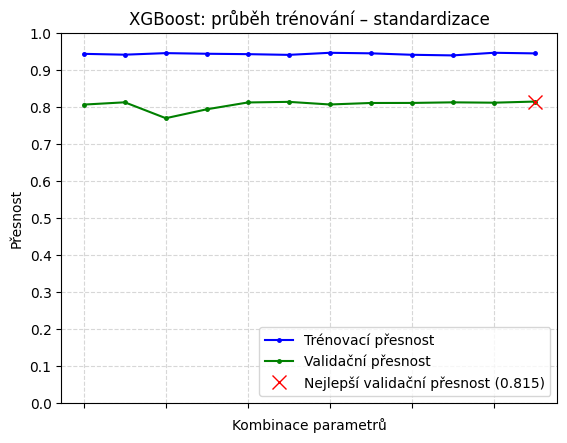

In [21]:
# print_results(best_xgb_standard, Xtrain_standard, Ytrain_from_zero, Xval_standard, Yval_from_zero, best_params_xgb_standard, train_acc_xgb_standard, val_acc_xgb_standard, 'XGBoost', 'standardizace', save=True, save_path='images/xgboost/xgb_standard2.png')
print_results(load_xgb_standard, Xtrain_standard, Ytrain_from_zero, Xval_standard, Yval_from_zero, load_xgb_standard_params, load_xgb_train_acc_standard, load_xgb_val_acc_standard, 'XGBoost', 'standardizace', save=False, save_path='images/xgboost/xgb_standard2.png')

Nepoužité příznaky v predikci: ['Early Warning', 'Malware', 'Political Extreme / Hate / Discrimination']


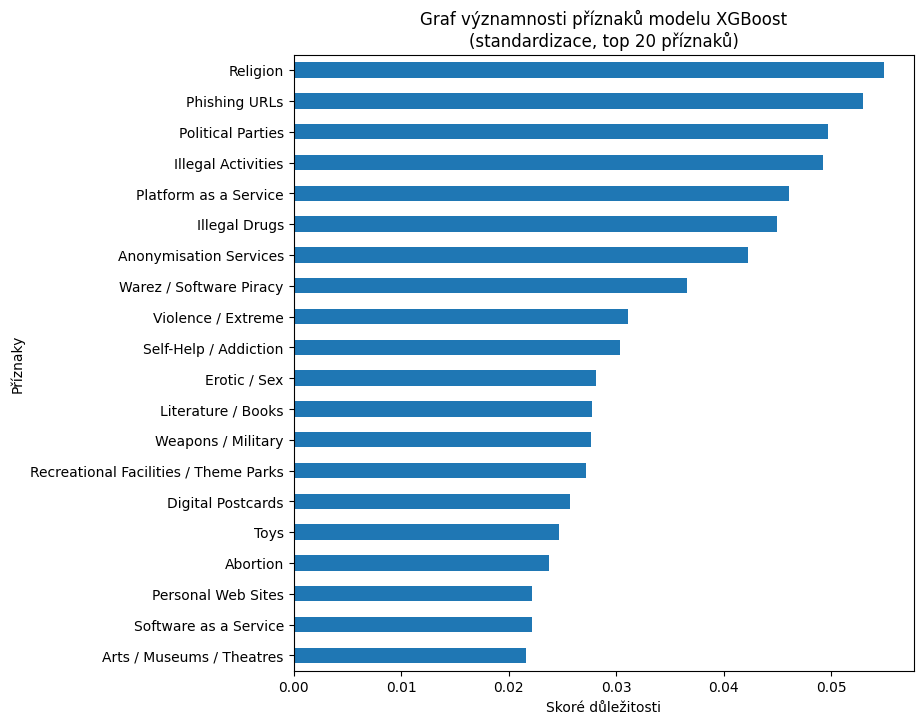

In [22]:
# print_feature_importance_xgb(best_xgb_standard, Xtrain_standard, 'XGBoost', 'standardizace', save=True, save_path='images/xgboost/xgb_standard_features2.png')
print_feature_importance_xgb(load_xgb_standard, Xtrain_standard, 'XGBoost', 'standardizace', save=False, save_path='images/xgboost/xgb_standard_features2.png')

___
### Model IV - PCA

In [15]:
train_acc_xgb_pca, val_acc_xgb_pca, best_xgb_pca, best_params_xgb_pca, best_score_xgb_pca = train_xgb(Xtrain_pca, Ytrain_from_zero, Xval_pca, Yval_from_zero, param_combs_xgb)

100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [2:23:42<00:00, 718.55s/it]


In [16]:
best_score_xgb_pca

0.5809548633737347

In [17]:
# pickle.dump(best_params_xgb_pca, open('best_models/xgboost/xgb_pca_params2.pkl', 'wb'))
# pickle.dump(best_xgb_pca, open('best_models/xgboost/xgb_pca2.pkl', 'wb'))
# pickle.dump(val_acc_xgb_pca, open('best_models/xgboost/xgb_pca_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_xgb_pca, open('best_models/xgboost/xgb_pca_train_acc2.pkl', 'wb'))

In [23]:
load_xgb_pca_params = pickle.load(open('best_models/xgboost/xgb_pca_params.pkl', 'rb'))
load_xgb_pca = pickle.load(open('best_models/xgboost/xgb_pca.pkl', 'rb'))
load_xgb_val_acc_pca = pickle.load(open('best_models/xgboost/xgb_pca_val_acc.pkl', 'rb'))
load_xgb_train_acc_pca = pickle.load(open('best_models/xgboost/xgb_pca_train_acc.pkl', 'rb'))


Nejlepší parametry: {'device': 'cuda', 'eval_metric': 'mlogloss', 'lambda': 2, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 200, 'num_class': 1727, 'objective': 'multi:softmax'}

Trénovací přesnost (accuracy): 0.94969
Validační přesnost (accuracy): 0.58095

Validační preciznost (precision): 0.596
Validační senzitivita (recall): 0.580
Validační F1 skóre: 0.579

Model predikoval 1725 (99.9 %) unikátních tříd. Neumí predikovat 2 (0.1 %) tříd.



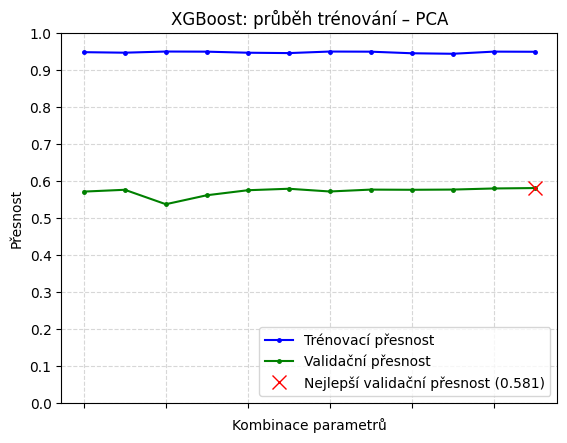

In [24]:
# print_results(best_xgb_pca, Xtrain_pca, Ytrain_from_zero, Xval_pca, Yval_from_zero, best_params_xgb_pca, train_acc_xgb_pca, val_acc_xgb_pca, 'XGBoost', 'PCA', save=True, save_path='images/xgboost/xgb_pca2.png')
print_results(load_xgb_pca, Xtrain_pca, Ytrain_from_zero, Xval_pca, Yval_from_zero, load_xgb_pca_params, load_xgb_train_acc_pca, load_xgb_val_acc_pca, 'XGBoost', 'PCA', save=False, save_path='images/xgboost/xgb_pca2.png')

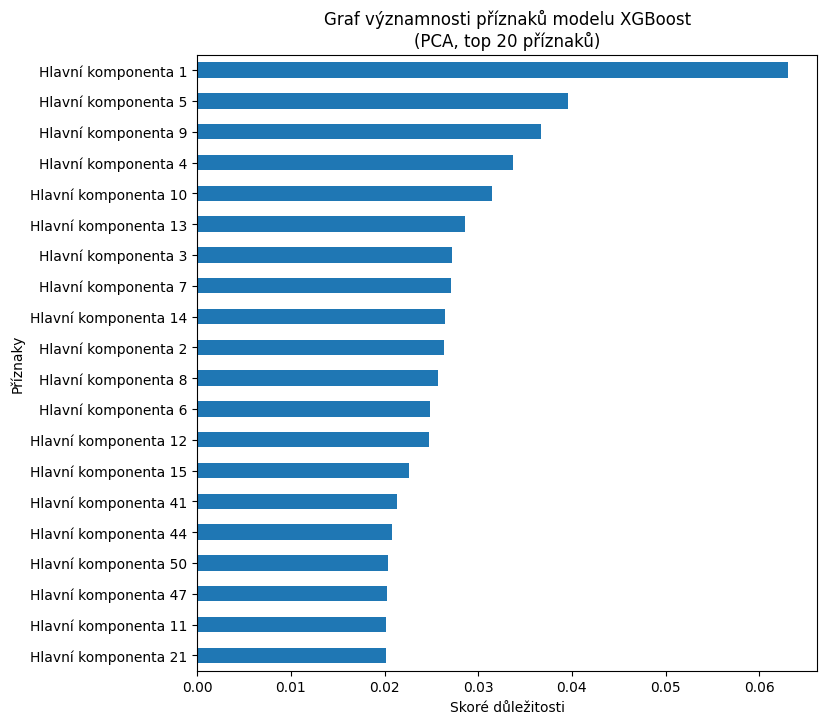

In [28]:
# print_feature_importance(best_xgb_pca, Xtrain_pca, 'XGBoost', 'PCA', save=True, save_path='images/xgboost/xgb_pca_features2.png')
print_feature_importance(load_xgb_pca, Xtrain_pca, 'XGBoost', 'PCA', save=False, save_path='images/xgboost/xgb_pca_features2.png')

Stejně jako u náhodného lesa jsou modely (mimo PCA) výkonostně téměř totožné. Celková přesnost modelů je ovšem velmi dobrá. Daleko přesahuje přesnosti náhodného lesa a zároveň byla pokořena i hranice přesnosti 80 %. To je na úlohu s tolika třídami velmi dobrý výsledek.

PCA je rozdílné u XGBoostu oproti náhodnému lesu v tom, že trénovací přesnost je zde stejná jako u ostatních typů dat na tomto modelu. Validační přesnost je ale ve velkém nepoměru. Zajímavé pozorování je, že PCA XGBoost se naučil predikovat nejvíce tříd ze všech modelů. Pouze 2 nedokázal rozslišit.

Celkově XGBoost ukazuje vysokou kvalitu v celkovém počtu predikovaných IP adres. Je vidět, že přístup _boostingu_ se na takový počet tříd hodí.

Poslední zajímavý fakt je, že první tři modely dělají predikci bez jakéhokoliv zásahu těchto příznaků `Early Warning`, `Malware`, `Political Extreme / Hate / Discrimination`.

___
# 3) Naivní Bayesův klasifikátor

V `sklearn` existuje několik verzí implementace naivního Bayese. Pro tuto úlohu a formát dat bude ovšem nejpravděpodobněji dávat nejlepší výsledky `MultinomialNB`. Ten počítá s tím, že jsou data z multinomického rozdělení (složky nabývají nezáporných celočíselných hodnot, nezávislé pokusy). Kvůli tomu nemá smysl na `MultinomialNB` aplikovat min-max / standardizovaná / PCA data.

Alternativou je použití `BernoulliNB`, který převádí jednotlivé hodnoty příznaků podle parametru `binarize` na 0, nebo 1. Bude tak také vyzkoušen.

Poslední možností by bylo teoretické použití `GaussianNB`. Ten předpokládá práci s daty ze spojitého normálního rozdělení. To ale data této úlohy nesplňují. Model by i tak šlo použít - predikce by nějakým způsobem vyšla - ale kvůli předpokladu normality není zaručena stabilita a robustnost predikce. Nebude tak použit.

Naivní Bayesův klasifikátor je nejjednodušším modelem použitým v této práci. Povaha příznaků (doménových kategorií) je ovšem velmi lákavá, aby byla nasazena právě na tento model.

In [12]:
def train_NB(trainX, trainY, valX, valY, param_comb):
    best_score = -1
    best_model = None
    best_params = None
    train_acc = []
    val_acc = []
    
    for combination in tqdm(param_comb):
        clfNB = MultinomialNB(alpha=combination['alpha'], fit_prior=False)
        clfNB.fit(trainX, trainY)
        
        y_train_pred = clfNB.predict(trainX)
        y_val_pred = clfNB.predict(valX)
        
        train = metrics.accuracy_score(trainY, y_train_pred)
        val = metrics.accuracy_score(valY, y_val_pred)

        val_acc.append(val)
        train_acc.append(train)
        
        if val > best_score:
            best_score = val
            best_model = clfNB
            best_params = combination
    return train_acc, val_acc, best_model, best_params, best_score

In [38]:
def train_bin_NB(trainX, trainY, valX, valY, param_comb):
    best_score = -1
    best_model = None
    best_params = None
    train_acc = []
    val_acc = []
    
    for combination in tqdm(param_comb):
        clfNB = BernoulliNB(alpha=combination['alpha'], binarize=combination['binarize'], fit_prior=False)
        clfNB.fit(trainX, trainY)
        
        y_train_pred = clfNB.predict(trainX)
        y_val_pred = clfNB.predict(valX)
        
        train = metrics.accuracy_score(trainY, y_train_pred)
        val = metrics.accuracy_score(valY, y_val_pred)

        val_acc.append(val)
        train_acc.append(train)
        
        if val > best_score:
            best_score = val
            best_model = clfNB
            best_params = combination
    return train_acc, val_acc, best_model, best_params, best_score

In [57]:
def get_feature_importance_NB(trainX, trainY, model, model_name, data_type, show=True, save=False, save_path=None):
    importance = {}
    base_acc = 0

    for col in tqdm(range(len(trainX.columns)+1)):
        tmp_trainX = trainX.copy()
        if col != 0:
            tmp_trainX[tmp_trainX.columns[col-1]] = np.random.permutation(tmp_trainX[tmp_trainX.columns[col-1]].values)
        
        current_acc = metrics.accuracy_score(trainY, model.predict(tmp_trainX))

        if col != 0:
            importance[tmp_trainX.columns[col-1]] = base_acc - current_acc
        else:
            base_acc = current_acc
    
    print(f'Trénovací přesnost: {base_acc:.3f}')
    total = sum(importance.values())
    norm_importance = {k: v / total for k, v in importance.items()}
    norm_importance = sorted(norm_importance.items(), key=lambda item: item[1], reverse=True)[:20]
    keys, values = zip(*norm_importance)

    plt.figure(figsize=(8, 8))
    plt.barh(keys, values)
    plt.ylabel('Příznaky')
    plt.xlabel('Skoré důležitosti')
    plt.title(f'Graf významnosti příznaků modelu {model_name}\n({data_type}, top 20 příznaků)')
    plt.gca().invert_yaxis()
    if save and save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)

____
### Model I - základní data

In [14]:
param_grid_NB = {
    'alpha': [1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-5, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 1, 1.5, 2, 5, 10, 20, 30, 50, 100, 1000],
}
param_comb_NB = ParameterGrid(param_grid_NB)
# print(len(param_comb_NB))

In [16]:
train_acc_NB_classic, val_acc_NB_classic, best_NB_classic, best_params_NB_classic, best_score_NB_classic = train_NB(Xtrain, Ytrain, Xval, Yval, param_comb_NB)

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [13:27<00:00, 32.32s/it]


In [17]:
best_score_NB_classic

0.661192927581563

In [33]:
# pickle.dump(best_params_NB_classic, open('best_models/naive_bayes/NB_classic_params2.pkl', 'wb'))
# pickle.dump(best_NB_classic, open('best_models/naive_bayes/NB_classic2.pkl', 'wb'))
# pickle.dump(val_acc_NB_classic, open('best_models/naive_bayes/NB_classic_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_NB_classic, open('best_models/naive_bayes/NB_classic_train_acc2.pkl', 'wb'))

In [42]:
load_NB_classic_params = pickle.load(open('best_models/naive_bayes/NB_classic_params.pkl', 'rb'))
load_NB_classic = pickle.load(open('best_models/naive_bayes/NB_classic.pkl', 'rb'))
load_NB_val_acc_classic = pickle.load(open('best_models/naive_bayes/NB_classic_val_acc.pkl', 'rb'))
load_NB_train_acc_classic = pickle.load(open('best_models/naive_bayes/NB_classic_train_acc.pkl', 'rb'))


Nejlepší parametry: {'alpha': 1e-12}

Trénovací přesnost (accuracy): 0.68608
Validační přesnost (accuracy): 0.66119

Validační preciznost (precision): 0.690
Validační senzitivita (recall): 0.660
Validační F1 skóre: 0.655

Model predikoval 1665 (96.4 %) unikátních tříd. Neumí predikovat 62 (3.6 %) tříd.



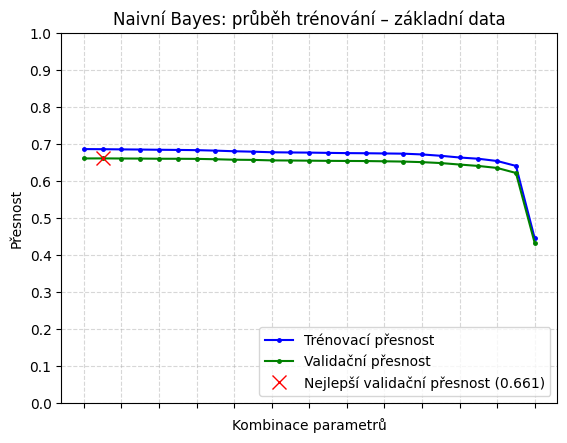

In [43]:
# print_results(best_NB_classic, Xtrain, Ytrain, Xval, Yval, best_params_NB_classic, train_acc_NB_classic, val_acc_NB_classic, 'Naivní Bayes', 'základní data', save=True, save_path='images/naive_bayes/NB_classic2.png')
print_results(load_NB_classic, Xtrain, Ytrain, Xval, Yval, load_NB_classic_params, load_NB_train_acc_classic, load_NB_val_acc_classic, 'Naivní Bayes', 'základní data', save=False, save_path='images/naive_bayes/NB_classic2.png')

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [01:23<00:00,  1.05s/it]


Trénovací přesnost: 0.686


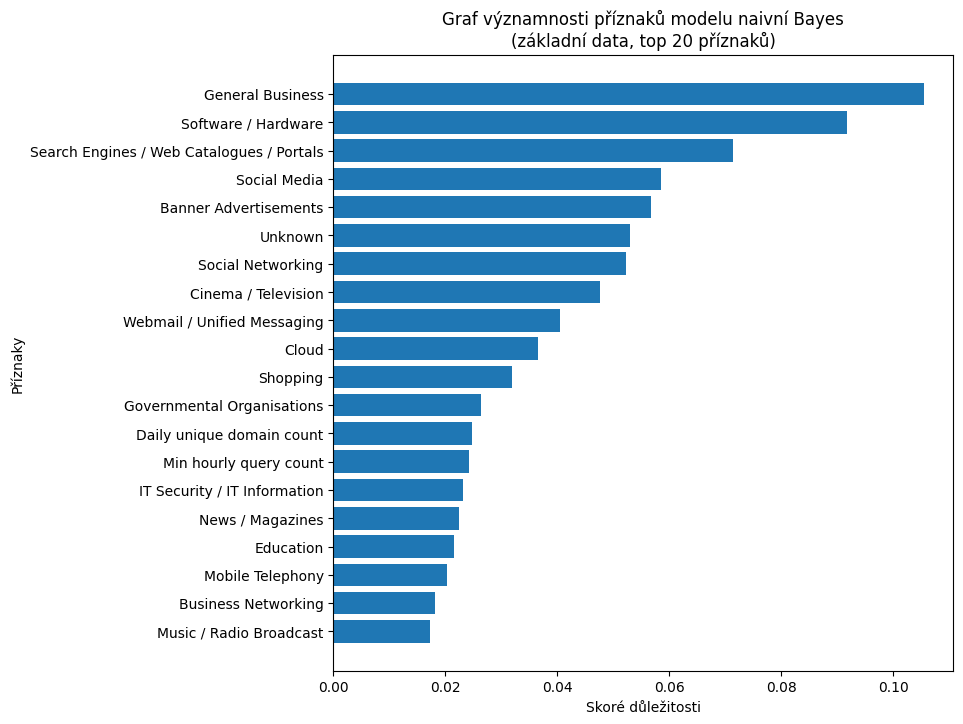

In [46]:
get_feature_importance_NB(Xtrain, Ytrain, load_NB_classic, 'naivní Bayes', 'základní data', save=True, save_path='images/naive_bayes/NB_classic_features2.png')

(https://christophm.github.io/interpretable-ml-book/feature-importance.html)

Významnost příznaků je zde ukázána jen u nejlepšího modelu. Naivní Bayes ovšem nedisponuje žádnou zabudovanou metodou pro vypočtení důležitosti příznaků. Je k tomu tak použita tzv. `Permutation Feature Importance`. Ta funguje na principu, že se pro každý příznak (zvlášť) promíchají jeho hodnoty a následně se na takto upravených datech udělá predikce. Podle toho, jak se nová predikce mění (sníží) oproti původní "plnohodnotné" predikci se určí, jak je příznak pro model důležitý. Tato metoda je následně použita i u neuronových sítí.

___

In [36]:
param_grid_NB_Ber = {
    'alpha': [1e-13, 1e-11, 1e-7, 0.001, 0.1, 0.5, 1, 2,],
    'binarize': np.linspace(1e-13, 1, 5)
}
param_comb_NB_Ber = ParameterGrid(param_grid_NB_Ber)
print(len(param_comb_NB_Ber))

40


In [39]:
train_acc_NB_classic_ber, val_acc_NB_classic_ber, best_NB_classic_ber, best_params_NB_classic_ber, best_score_NB_classic_ber = train_bin_NB(Xtrain, Ytrain, Xval, Yval, param_comb_NB_Ber)

100%|█████████████████████████████████████████████████████████████████████████████████| 40/40 [23:40<00:00, 35.51s/it]


In [40]:
best_score_NB_classic_ber

0.3444545809983057


Nejlepší parametry: {'alpha': 0.1, 'binarize': np.float64(1e-13)}

Trénovací přesnost (accuracy): 0.39706
Validační přesnost (accuracy): 0.34445

Validační preciznost (precision): 0.343
Validační senzitivita (recall): 0.344
Validační F1 skóre: 0.319

Model predikoval 1569 (90.9 %) unikátních tříd. Neumí predikovat 158 (9.1 %) tříd.



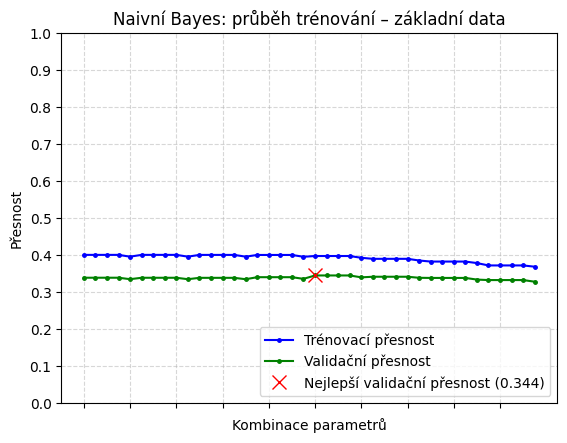

In [41]:
print_results(best_NB_classic_ber, Xtrain, Ytrain, Xval, Yval, best_params_NB_classic_ber, train_acc_NB_classic_ber, val_acc_NB_classic_ber, 'Naivní Bayes', 'základní data', save=False, save_path='images/naive_bayes/NB_classic2.png')

____
### Model II - minmax

In [47]:
param_grid_NB_Ber_minmax = {
    'alpha': [1e-13, 1e-11, 1e-7, 0.001, 0.1, 0.5, 1, 2,],
    'binarize': np.linspace(1e-13, 1e-5, 10)
}
param_comb_NB_Ber_minmax = ParameterGrid(param_grid_NB_Ber_minmax)
# print(len(param_comb_NB_Ber_minmax))

In [48]:
train_acc_NB_minmax, val_acc_NB_minmax, best_NB_minmax, best_params_NB_minmax, best_score_NB_minmax = train_bin_NB(Xtrain_minmax, Ytrain, Xval_minmax, Yval, param_comb_NB_Ber_minmax)

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [03:04<00:00,  2.31s/it]


In [49]:
best_score_NB_minmax

0.34693079629870976

In [52]:
# pickle.dump(best_params_NB_minmax, open('best_models/naive_bayes/NB_minmax_params2.pkl', 'wb'))
# pickle.dump(best_NB_minmax, open('best_models/naive_bayes/NB_minmax2.pkl', 'wb'))
# pickle.dump(val_acc_NB_minmax, open('best_models/naive_bayes/NB_minmax_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_NB_minmax, open('best_models/naive_bayes/NB_minmax_train_acc2.pkl', 'wb'))

In [51]:
load_NB_minmax_params = pickle.load(open('best_models/naive_bayes/NB_minmax_params.pkl', 'rb'))
load_NB_minmax = pickle.load(open('best_models/naive_bayes/NB_minmax.pkl', 'rb'))
load_NB_val_acc_minmax = pickle.load(open('best_models/naive_bayes/NB_minmax_val_acc.pkl', 'rb'))
load_NB_train_acc_minmax = pickle.load(open('best_models/naive_bayes/NB_minmax_train_acc.pkl', 'rb'))


Nejlepší parametry: {'alpha': 0.1, 'binarize': np.float64(6.6666667e-06)}

Trénovací přesnost (accuracy): 0.39929
Validační přesnost (accuracy): 0.34693

Validační preciznost (precision): 0.344
Validační senzitivita (recall): 0.346
Validační F1 skóre: 0.321

Model predikoval 1571 (91.0 %) unikátních tříd. Neumí predikovat 156 (9.0 %) tříd.



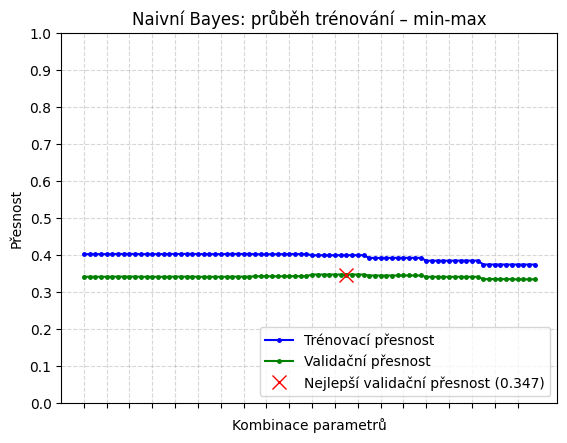

In [54]:
# print_results(best_NB_minmax, Xtrain_minmax, Ytrain, Xval_minmax, Yval, best_params_NB_minmax, train_acc_NB_minmax, val_acc_NB_minmax, 'Naivní Bayes', 'min-max', save=True, save_path='images/naive_bayes/NB_minmax2.png')
print_results(load_NB_minmax, Xtrain_minmax, Ytrain, Xval_minmax, Yval, load_NB_minmax_params, load_NB_train_acc_minmax, load_NB_val_acc_minmax, 'Naivní Bayes', 'min-max', save=False, save_path='images/naive_bayes/NB_minmax2.png')

____
### Model III - standardizace

In [58]:
param_grid_NB_Ber_standard = {
    'alpha': [1e-13, 1e-11, 1e-7, 0.001, 0.1, 0.5, 1, 2,],
    'binarize': np.linspace(1e-13, 1e-5, 10)
}
param_comb_NB_Ber_standard = ParameterGrid(param_grid_NB_Ber_standard)
# print(len(param_comb_NB_Ber_standard))

In [59]:
train_acc_NB_standard, val_acc_NB_standard, best_NB_standard, best_params_NB_standard, best_score_NB_standard = train_bin_NB(Xtrain_standard, Ytrain, Xval_standard, Yval, param_comb_NB_Ber_standard)

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [03:03<00:00,  2.30s/it]


In [60]:
best_score_NB_standard

0.5144445892523567

In [61]:
# pickle.dump(best_params_NB_standard, open('best_models/naive_bayes/NB_standard_params2.pkl', 'wb'))
# pickle.dump(best_NB_standard, open('best_models/naive_bayes/NB_standard2.pkl', 'wb'))
# pickle.dump(val_acc_NB_standard, open('best_models/naive_bayes/NB_standard_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_NB_standard, open('best_models/naive_bayes/NB_standard_train_acc2.pkl', 'wb'))

In [75]:
load_NB_standard_params = pickle.load(open('best_models/naive_bayes/NB_standard_params.pkl', 'rb'))
load_NB_standard = pickle.load(open('best_models/naive_bayes/NB_standard.pkl', 'rb'))
load_NB_val_acc_standard = pickle.load(open('best_models/naive_bayes/NB_standard_val_acc.pkl', 'rb'))
load_NB_train_acc_standard = pickle.load(open('best_models/naive_bayes/NB_standard_train_acc.pkl', 'rb'))


Nejlepší parametry: {'alpha': 0.1, 'binarize': np.float64(1e-13)}

Trénovací přesnost (accuracy): 0.56127
Validační přesnost (accuracy): 0.51444

Validační preciznost (precision): 0.567
Validační senzitivita (recall): 0.513
Validační F1 skóre: 0.521

Model predikoval 1559 (90.3 %) unikátních tříd. Neumí predikovat 168 (9.7 %) tříd.



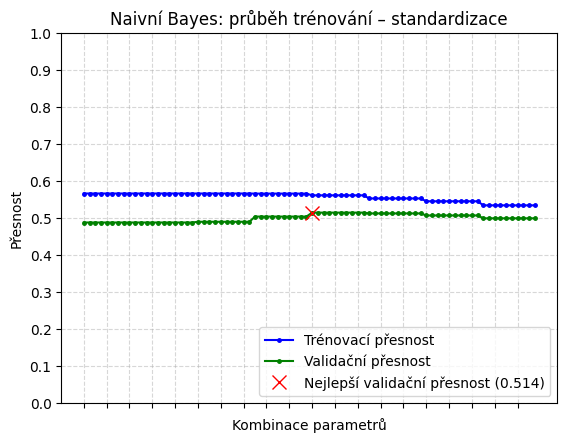

In [76]:
# print_results(best_NB_standard, Xtrain_standard, Ytrain, Xval_standard, Yval, best_params_NB_standard, train_acc_NB_standard, val_acc_NB_standard, 'Naivní Bayes', 'standardizace', save=True, save_path='images/naive_bayes/NB_standard2.png')
print_results(load_NB_standard, Xtrain_standard, Ytrain, Xval_standard, Yval, load_NB_standard_params, load_NB_train_acc_standard, load_NB_val_acc_standard, 'Naivní Bayes', 'standardizace', save=False, save_path='images/naive_bayes/NB_standard2.png')

____
### Model IV - PCA

In [70]:
param_grid_NB_Ber_pca = {
    'alpha': [1e-13, 1e-11, 1e-7, 0.001, 0.1, 0.5, 1, 2,],
    'binarize': np.linspace(1e-13, 1, 10)
}
param_comb_NB_Ber_pca = ParameterGrid(param_grid_NB_Ber_pca)
# print(len(param_comb_NB_Ber_pca))

In [71]:
train_acc_NB_pca, val_acc_NB_pca, best_NB_pca, best_params_NB_pca, best_score_NB_pca = train_bin_NB(Xtrain_pca, Ytrain, Xval_pca, Yval, param_comb_NB_Ber_pca)

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [02:54<00:00,  2.18s/it]


In [72]:
best_score_NB_pca

0.2711238542073939

In [73]:
# pickle.dump(best_params_NB_pca, open('best_models/naive_bayes/NB_pca_params2.pkl', 'wb'))
# pickle.dump(best_NB_pca, open('best_models/naive_bayes/NB_pca2.pkl', 'wb'))
# pickle.dump(val_acc_NB_pca, open('best_models/naive_bayes/NB_pca_val_acc2.pkl', 'wb'))
# pickle.dump(train_acc_NB_pca, open('best_models/naive_bayes/NB_pca_train_acc2.pkl', 'wb'))

In [77]:
load_NB_pca_params = pickle.load(open('best_models/naive_bayes/NB_pca_params.pkl', 'rb'))
load_NB_pca = pickle.load(open('best_models/naive_bayes/NB_pca.pkl', 'rb'))
load_NB_val_acc_pca = pickle.load(open('best_models/naive_bayes/NB_pca_val_acc.pkl', 'rb'))
load_NB_train_acc_pca = pickle.load(open('best_models/naive_bayes/NB_pca_train_acc.pkl', 'rb'))


Nejlepší parametry: {'alpha': 1e-13, 'binarize': np.float64(0.1111111111112)}

Trénovací přesnost (accuracy): 0.30566
Validační přesnost (accuracy): 0.27112

Validační preciznost (precision): 0.299
Validační senzitivita (recall): 0.270
Validační F1 skóre: 0.257

Model predikoval 1601 (92.7 %) unikátních tříd. Neumí predikovat 126 (7.3 %) tříd.



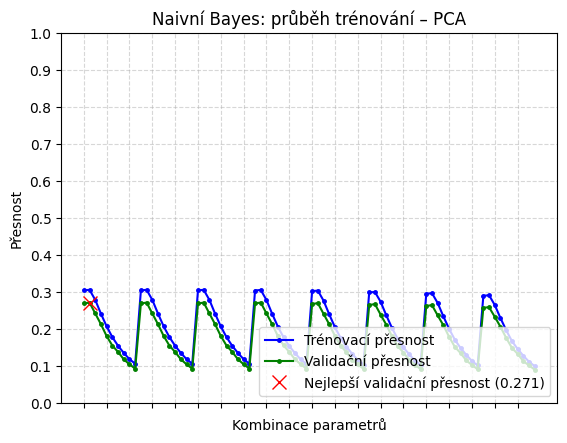

In [79]:
# print_results(best_NB_pca, Xtrain_pca, Ytrain, Xval_pca, Yval, best_params_NB_pca, train_acc_NB_pca, val_acc_NB_pca, 'Naivní Bayes', 'PCA', save=True, save_path='images/naive_bayes/NB_pca2.png')
print_results(load_NB_pca, Xtrain_pca, Ytrain, Xval_pca, Yval, load_NB_pca_params, load_NB_train_acc_pca, load_NB_val_acc_pca, 'Naivní Bayes', 'PCA', save=False, save_path='images/naive_bayes/NB_pca2.png')

Naivní Bayes celkově nepodal dobré výsledky. I když nejlepší model dosáhl validační přesnosti 66 %, nedosahuje to potřebných kvalit. Jediným pozitivem je, že se model dokázal naučit predikovat 96,4 % tříd, co není špatné z toho pohledu, že jediné na čem stojí jsou podmíněné pravděpodobnosti. Na PCA datech nedokázal Naivní Bayes predikovat téměř vůbec.

____
# 4) Vícevrstvý perceptron (MLP)

Asi nejvíce očekávání je (stejně jako obecně v dnešní době) od neuronových sítí. Díky své struktuře se dokážou dobře naučit predikovat i nelineární struktury v datech, což je mnohdy potřeba.

Formát dat (tenzorů), použitý pro vstup do neuronových sítí  je $[N,C,L]$, kde:

- N = počet datových bodů
- C = počet kanálů (důležité hlavně pro konvoluční neuronové sítě)
- L = délka vstupního signálu/sekvence

(Pro obrázková data se např. používá formát \[N,C,H,W], kde H = # pixelů na výšku a W = # pixelů na šířku

Ladit hyperparametry u neuronových sítí je složitá úloha. Je jich velké množství a architektura neuronových sítí není vlastně žádným způsobem omezena. Jedná se tak o "sandbox", ve kterém je třeba se pro danou úlohu umět zorientovat. Základní hyperparametry k ladění jsou - _hloubka sítě_, _počet neuronů ve vrstvách_, _dropout_, _aktivační funkce_, _learning rate_, (_velikost dávek_). 

Jako ztrátová funkce bude použita `CrossEntropyLoss` (s parametrem _label_smoothing_, který upravuje váhy ve výpočtu ztrátové funkce; "změkčuje" je; jde o regularizační techniku) a jako optimizér `Adam`. Například klasický optimizér `SGD` se nebyl schopen téměř nic naučit.

Trénink probíhal vytvořením základní architektury neuronové sítě s malým počtem vrstev. Následně se ladil počet neuronů ve vrstvách, následovaného přidáváním nových vrstev. Pro regularizaci byl přidán i dropout. V každém kroku se zkoušela obměňovat i aktivační funkce, nicméně funkce `SELU` stabilně podávala o cca 1-2 % lepší výkon v přesnostech.

\[Díky možnosti v `PyTorch` využít GPU při trénování (při zpětném chodu) se neuronové sítě trénovali vcelku rychle, a proto byla možnost vyzkoušet mnoho kombinací.]

Funkce definované níže slouží k přípravě dat pro trénování a dávkovému trénování.

In [12]:
def prepare_loader(batch_size=32, minmax=False, standard=False, PCAA=False, **kwargs):
    passed_args = locals()
    print(f'Nastavení: {passed_args}')
    
    Ytrain_mod = np.asarray(Ytrain_from_zero, dtype=np.float32)
    Yval_mod = np.asarray(Yval_from_zero, dtype=np.float32)
    if minmax:
        Xtrain_mod = Xtrain_minmax.to_numpy()
        Xval_mod = Xval_minmax.to_numpy()
    elif standard:
        Xtrain_mod = Xtrain_standard.to_numpy()
        Xval_mod = Xval_standard.to_numpy()
    elif PCAA:
        Xtrain_mod = Xtrain_pca.to_numpy()
        Xval_mod = Xval_pca.to_numpy()
    else:
        Xtrain_mod = Xtrain.to_numpy()
        Xval_mod = Xval.to_numpy()

    print('\n===NumPy===')
    print(Xtrain_mod.shape, Ytrain_mod.shape)
    print(Xval_mod.shape, Yval_mod.shape)

    if PCAA:
        Xtrain_mod = Xtrain_mod.reshape(-1,1,kwargs['n_comps'])
        Xval_mod = Xval_mod.reshape(-1,1,kwargs['n_comps'])
    else:
        Xtrain_mod = Xtrain_mod.reshape(-1,1,79)
        Xval_mod = Xval_mod.reshape(-1,1,79)
    
    print('\n===Reshaped===')
    print(Xtrain_mod.shape, Ytrain_mod.shape)
    print(Xval_mod.shape, Yval_mod.shape)

    Xtrain_tensor = torch.tensor(Xtrain_mod, dtype=torch.float)
    Ytrain_tensor = torch.tensor(Ytrain_mod, dtype=torch.long)
    
    Xval_tensor = torch.tensor(Xval_mod, dtype=torch.float)
    Yval_tensor = torch.tensor(Yval_mod, dtype=torch.long)

    train_dataset = torch.utils.data.TensorDataset(Xtrain_tensor, Ytrain_tensor)
    val_dataset = torch.utils.data.TensorDataset(Xval_tensor, Yval_tensor)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
    
    print(f'\nPočet bodů v trénovacím datasetu: {len(train_dataset)}')
    print(f'Počet bodů ve validačním datasetu: {len(val_dataset)}')

    return len(train_dataset), len(val_dataset), train_loader, val_loader

________

In [13]:
def train_one_epoch(model, loss_fn, optimizer, train_loader, len_train, l_reg_alpha):
    correct = 0

    for i, data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)

        #  L1 regularizace
        l_reg = torch.tensor(0., device=inputs.device)
        l_reg += torch.linalg.vector_norm(model.fco.weight.flatten(),1)
        loss = loss + l_reg_alpha * l_reg
        
        loss.backward()
        optimizer.step()

        inputs, labels = inputs.cpu(), labels.cpu()
    
        correct += (outputs.cpu().argmax(1) == labels).float().sum()
            
    return correct / len_train

In [14]:
def train_model(model, loss_fn, optimizer, len_train, len_val, train_loader, val_loader, l_reg_alpha, MAX_EPOCHS, NO_IMPROVE_EPOCHS, model_path):
    epochs_from_best = 0
    
    epochs = []
    train_acc = []
    validation_acc = []
    best_vacc = -1.
    
    for epoch in range(MAX_EPOCHS):
        print(f'EPOCHA {epoch+1}:')
    
        model.train(True)
        tacc = train_one_epoch(model, loss_fn, optimizer, train_loader, len_train, l_reg_alpha)
        model.train(False)
    
        vcorrect = 0
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.cuda(), vlabels.cuda()
            with torch.no_grad():
                voutputs = model(vinputs)
            vinputs, vlabels = vinputs.cpu(), vlabels.cpu()
            vcorrect += (voutputs.cpu().argmax(1) == vlabels).float().sum()
        vacc = vcorrect / len_val
        
        clear_output(wait=True)
        print(f'EPOCHA {epoch+1}:')
        print(f'TRÉNOVACÍ přesnost: {tacc:.3f}, VALIDAČNÍ přesnost: {vacc:.3f}')
    
        epochs.append(epoch)
        validation_acc.append(vacc)
        train_acc.append(tacc)
        
        if vacc > best_vacc:
            print('Ukládání nejlepšího modelu')
            best_vacc = vacc
            torch.save(model.state_dict(), model_path)
            epochs_from_best = 0
        else:
            epochs_from_best += 1
            print(f'Žádné zlepšení v rámci této epochy. ({epochs_from_best})')
            
        if epochs_from_best > NO_IMPROVE_EPOCHS:
            print('Předčasné zastavení')
            break
    return epochs, train_acc, validation_acc, best_vacc

___

Pomocné funkce pro vizualizaci výstupů a průběhu trénování.

In [15]:
def print_progress(epochs, train_acc, validation_acc, best_vacc, model_name, data_type, show=True, save=False, save_path=None):
    epochs = np.array(epochs)
    validation_acc = np.array(validation_acc)
    plt.plot(epochs,train_acc, '.-', markersize = 5, label='Trénovací přesnost', color = 'blue')
    plt.plot(epochs,validation_acc, '.-', markersize = 5, label='Validační přesnost', color = 'green')
    plt.plot([epochs[np.argmax(validation_acc)]], [validation_acc[np.argmax(validation_acc)]],'x', color = 'red', markersize = 10, label=f'Nejlepší validační přesnost ({best_vacc:.3f})')
    plt.title(f'{model_name}: průběh trénování –⁠⁠⁠⁠⁠⁠ {data_type}')
    tick=range(len(epochs))[::10] if len(train_acc) <= 100 else range(len(train_acc))[::20] if len(train_acc) <= 300 else range(len(train_acc))[::30]
    plt.xticks(ticks=tick)
    plt.xlabel('Epocha')
    plt.ylabel('Přesnost')
    plt.ylim(bottom=0, top=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))
    plt.grid(which='major', axis='y', linestyle='--')
    plt.legend(loc='lower right')
    if save and save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)

In [16]:
def predict_NN(model, dataset, loader):
    model.eval()
    predictions = np.zeros(len(dataset))
    y = np.zeros(len(dataset))
    ii = 0
    for data in loader:
        inputs, labels = data
        with torch.no_grad():
            outputs = model(inputs)
        predictions[ii:(ii + inputs.shape[0])] = outputs.argmax(1).numpy()
        y[ii:(ii + inputs.shape[0])] = labels.numpy()
        ii += inputs.shape[0]
    return metrics.accuracy_score(y, predictions)

In [17]:
def get_feature_importance_NN(trainX, trainY, model, model_name, data_type, show=True, save=False, save_path=None):
    importance = {}
    base_acc = 0

    for col in tqdm(range(len(trainX.columns)+1)):
        tmp_trainX = trainX.copy()
        if col != 0:
            tmp_trainX[tmp_trainX.columns[col-1]] = np.random.permutation(tmp_trainX[tmp_trainX.columns[col-1]].values)
        Xtrain_features = tmp_trainX .to_numpy()
        Ytrain_features = np.asarray(trainY, dtype=np.float32)
        
        Xtrain_features = Xtrain_features.reshape(-1,1,79)
        
        Xtrain_features_tensor = torch.tensor(Xtrain_features, dtype = torch.float)
        Ytrain_features_tensor = torch.tensor(Ytrain_features, dtype=torch.long)
    
        Xtrain_features_dataset = torch.utils.data.TensorDataset(Xtrain_features_tensor, Ytrain_features_tensor)
        Xtrain_features_loader = torch.utils.data.DataLoader(Xtrain_features_dataset, batch_size=2048, shuffle=False)
    
        current_acc = predict_NN(model, Xtrain_features_dataset, Xtrain_features_loader)

        if col != 0:
            importance[tmp_trainX.columns[col-1]] = base_acc - current_acc
        else:
            base_acc = current_acc
    
    print(f'Trénovací přesnost: {base_acc:.3f}')
    total = sum(importance.values())
    norm_importance = {k: v / total for k, v in importance.items()}
    norm_importance = sorted(norm_importance.items(), key=lambda item: item[1], reverse=True)[:20]
    keys, values = zip(*norm_importance)

    plt.figure(figsize=(8, 8))
    plt.barh(keys, values)
    plt.ylabel('Příznaky')
    plt.xlabel('Skoré důležitosti')
    plt.title(f'Graf významnosti příznaků modelu {model_name}\n({data_type}, top 20 příznaků)')
    plt.gca().invert_yaxis()
    if save and save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)

In [21]:
def fina_eval_NN(model, len_dataset, loader, data_set):
    model.eval()
    predictions = np.zeros(len_dataset)
    y = np.zeros(len_dataset)
    print(predictions.shape)
    ii = 0
    for data in tqdm(loader):
        inputs, labels = data
        with torch.no_grad():
            outputs = model(inputs)
        predictions[ii:(ii + inputs.shape[0])] = outputs.argmax(1).numpy()
        y[ii:(ii + inputs.shape[0])] = labels.numpy()
        ii += inputs.shape[0]

    print(f'\n{data_set} přesnost (accuracy): {metrics.accuracy_score(y, predictions):.5f}')
    print(f'\n{data_set} preciznost (precision): {metrics.precision_score(y, predictions, average="macro", zero_division=0.0):.5f}')
    print(f'\n{data_set} senzitivita (recall): {metrics.recall_score(y, predictions, average="macro", zero_division=0.0):.5f}')
    print(f'\n{data_set} F1 skóre: {metrics.f1_score(y, predictions, average="macro", zero_division=0.0):.5f}')
    if data_set == 'Trénovací':
        unique_predictions = len(set(predictions))
        print(f'\nModel predikoval {unique_predictions} ({(unique_predictions/1727)*100:.2f} %) unikátních tříd. Neumí predikovat {1727 - unique_predictions} ({((1727 - unique_predictions)/1727)*100:.2f} %) tříd.\n')

________

### Model I - základní data

In [29]:
class FeedforwardNN_classic(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(79, 128)
        self.fc2 = nn.Linear(128, 256)
        # self.drop1 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 2048)
        self.drop2 = nn.Dropout(p=0.1)
        self.fc6 = nn.Linear(2048, 1024)
        self.fco = nn.Linear(1024, 1727)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        # x = self.drop1(x)
        x = F.selu(self.fc3(x))
        x = F.selu(self.fc4(x))
        x = F.selu(self.fc5(x))
        x = self.drop2(x)
        x = F.selu(self.fc6(x))
        x = self.fco(x)
        return x

model = FeedforwardNN_classic()

In [30]:
len_train, len_val, train_loader, val_loader = prepare_loader(batch_size=2048)

Nastavení: {'batch_size': 2048, 'minmax': False, 'standard': False, 'PCAA': False, 'kwargs': {}}

===NumPy===
(105777, 79) (105777,)
(23019, 79) (23019,)

===Reshaped===
(105777, 1, 79) (105777,)
(23019, 1, 79) (23019,)

Počet bodů v trénovacím datasetu: 105777
Počet bodů ve validačním datasetu: 23019


In [182]:
dataiter = iter(train_loader)
data, labels = next(dataiter)

outputs = model(data)
print(data.shape, outputs.shape)

num_params = 0
for name, param in model.named_parameters():
    print(f"{name}\n# {param.numel()}")
    num_params += param.numel()
    
print(f"\nCelkový počet parametrů: {num_params}")

torch.Size([2048, 1, 79]) torch.Size([2048, 1727])
fc1.weight
# 10112
fc1.bias
# 128
fc2.weight
# 32768
fc2.bias
# 256
fc3.weight
# 131072
fc3.bias
# 512
fc4.weight
# 524288
fc4.bias
# 1024
fc5.weight
# 2097152
fc5.bias
# 2048
fc6.weight
# 2097152
fc6.bias
# 1024
fco.weight
# 1768448
fco.bias
# 1727

Celkový počet parametrů: 6667711


In [183]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [184]:
# .cuda() = přesun objektu z CPU na GPU
model.cuda();
epochs, train_acc, validation_acc, best_vacc = train_model(model, loss_fn, optimizer, len_train, len_val, train_loader, val_loader, 0, 400, 100, 'best_models/NN_classic/feedforwardNN_classic2.pt')
model.cpu();

EPOCHA 400:
TRÉNOVACÍ přesnost: 0.922, VALIDAČNÍ přesnost: 0.823
Žádné zlepšení v rámci této epochy. (10)


In [185]:
best_vacc

tensor(0.8237)

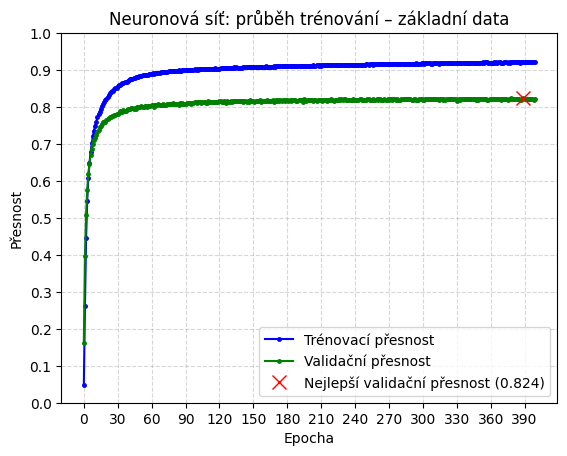

In [186]:
print_progress(epochs, train_acc, validation_acc, best_vacc, 'Neuronová síť', 'základní data', save=True, save_path='images/NN_classic/feedforwardNN_classic_graph2.png')

In [31]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_path = 'best_models/NN_classic/feedforwardNN_classic.pt'
model = FeedforwardNN_classic()
model.load_state_dict(torch.load(model_path))
model.eval()

FeedforwardNN_classic(
  (fc1): Linear(in_features=79, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=2048, bias=True)
  (drop2): Dropout(p=0.1, inplace=False)
  (fc6): Linear(in_features=2048, out_features=1024, bias=True)
  (fco): Linear(in_features=1024, out_features=1727, bias=True)
)

In [32]:
fina_eval_NN(model, len_train, train_loader, 'Trénovací')

(105777,)


100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:04<00:00, 12.35it/s]


Trénovací přesnost (accuracy): 0.92453

Trénovací preciznost (precision): 0.93802

Trénovací senzitivita (recall): 0.92019

Trénovací F1 skóre: 0.91936

Model predikoval 1710 (99.02 %) unikátních tříd. Neumí predikovat 17 (0.98 %) tříd.



In [33]:
fina_eval_NN(model, len_val, val_loader, 'Validační')

(23019,)


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:01<00:00, 151.83it/s]


Validační přesnost (accuracy): 0.82367

Validační preciznost (precision): 0.83011

Validační senzitivita (recall): 0.82222

Validační F1 skóre: 0.82027



__________
### Model II - minmax

In [34]:
class FeedforwardNN_minmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(79, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.drop1 = nn.Dropout(p=0.1)
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, 1024)
        self.fc7 = nn.Linear(1024, 2048)
        self.fco = nn.Linear(2048, 1727)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = F.selu(self.fc4(x))
        x = self.drop1(x)
        x = F.selu(self.fc5(x))
        x = F.selu(self.fc6(x))
        x = F.selu(self.fc7(x))
        x = self.fco(x)
        return x

model = FeedforwardNN_minmax()

In [35]:
len_train, len_val, train_loader, val_loader = prepare_loader(batch_size=2048, minmax=True)

Nastavení: {'batch_size': 2048, 'minmax': True, 'standard': False, 'PCAA': False, 'kwargs': {}}

===NumPy===
(105777, 79) (105777,)
(23019, 79) (23019,)

===Reshaped===
(105777, 1, 79) (105777,)
(23019, 1, 79) (23019,)

Počet bodů v trénovacím datasetu: 105777
Počet bodů ve validačním datasetu: 23019


In [210]:
dataiter = iter(train_loader)
data, labels = next(dataiter)

outputs = model(data)
print(data.shape, outputs.shape)

num_params = 0
for name, param in model.named_parameters():
    print(f"{name}\n# {param.numel()}")
    num_params += param.numel()
    
print(f"\nCelkový počet parametrů: {num_params}")

torch.Size([2048, 1, 79]) torch.Size([2048, 1727])
fc1.weight
# 10112
fc1.bias
# 128
fc2.weight
# 32768
fc2.bias
# 256
fc3.weight
# 131072
fc3.bias
# 512
fc4.weight
# 524288
fc4.bias
# 1024
fc5.weight
# 524288
fc5.bias
# 512
fc6.weight
# 524288
fc6.bias
# 1024
fc7.weight
# 2097152
fc7.bias
# 2048
fco.weight
# 3536896
fco.bias
# 1727

Celkový počet parametrů: 7388095


In [211]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [212]:
# .cuda() = přesun objektu z CPU na GPU
model.cuda();
epochs, train_acc, validation_acc, best_vacc = train_model(model, loss_fn, optimizer, len_train, len_val, train_loader, val_loader, 0, 400, 100, 'best_models/NN_classic/feedforwardNN_minmax2.pt')
model.cpu();

EPOCHA 400:
TRÉNOVACÍ přesnost: 0.886, VALIDAČNÍ přesnost: 0.824
Žádné zlepšení v rámci této epochy. (11)


In [213]:
best_vacc

tensor(0.8257)

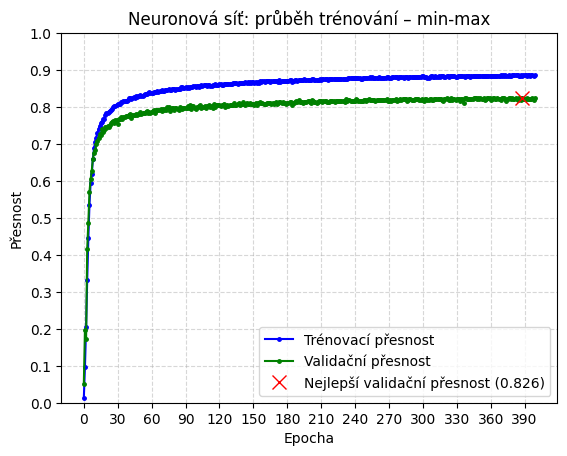

In [215]:
print_progress(epochs, train_acc, validation_acc, best_vacc, 'Neuronová síť', 'min-max', save=True, save_path='images/NN_classic/feedforwardNN_minmax_graph2.png')

In [36]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
model_path = 'best_models/NN_classic/feedforwardNN_minmax.pt'
model = FeedforwardNN_minmax()
model.load_state_dict(torch.load(model_path))
model.eval()

FeedforwardNN_minmax(
  (fc1): Linear(in_features=79, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (fc5): Linear(in_features=1024, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=2048, bias=True)
  (fco): Linear(in_features=2048, out_features=1727, bias=True)
)

In [37]:
fina_eval_NN(model, len_train, train_loader, 'Trénovací')

(105777,)


100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:05<00:00,  8.80it/s]


Trénovací přesnost (accuracy): 0.89205

Trénovací preciznost (precision): 0.89840

Trénovací senzitivita (recall): 0.88625

Trénovací F1 skóre: 0.88578

Model predikoval 1636 (94.73 %) unikátních tříd. Neumí predikovat 91 (5.27 %) tříd.



In [38]:
fina_eval_NN(model, len_val, val_loader, 'Validační')

(23019,)


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:01<00:00, 148.58it/s]


Validační přesnost (accuracy): 0.82571

Validační preciznost (precision): 0.83933

Validační senzitivita (recall): 0.82407

Validační F1 skóre: 0.82347


__________
### Model III - standardizace

In [23]:
class FeedforwardNN_standard(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(79, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.drop1 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 2048)
        self.drop2 = nn.Dropout(p=0.1)
        self.fc6 = nn.Linear(2048, 1024)
        self.fc7 = nn.Linear(1024, 1024)
        self.fco = nn.Linear(1024, 1727)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.drop1(x)
        x = F.selu(self.fc4(x))
        x = F.selu(self.fc5(x))
        x = self.drop2(x)
        x = F.selu(self.fc6(x))
        x = F.selu(self.fc7(x))
        x = self.fco(x)
        return x

model = FeedforwardNN_standard()

In [24]:
len_train, len_val, train_loader, val_loader = prepare_loader(batch_size=2048, standard=True)

Nastavení: {'batch_size': 2048, 'minmax': False, 'standard': True, 'PCAA': False, 'kwargs': {}}

===NumPy===
(105777, 79) (105777,)
(23019, 79) (23019,)

===Reshaped===
(105777, 1, 79) (105777,)
(23019, 1, 79) (23019,)

Počet bodů v trénovacím datasetu: 105777
Počet bodů ve validačním datasetu: 23019


In [72]:
dataiter = iter(train_loader)
data, labels = next(dataiter)

outputs = model(data)
print(data.shape, outputs.shape)

num_params = 0
for name, param in model.named_parameters():
    print(f"{name}\n# {param.numel()}")
    num_params += param.numel()
    
print(f"\nCelkový počet parametrů: {num_params}")

torch.Size([2048, 1, 79]) torch.Size([2048, 1727])
fc1.weight
# 10112
fc1.bias
# 128
fc2.weight
# 32768
fc2.bias
# 256
fc3.weight
# 131072
fc3.bias
# 512
fc4.weight
# 524288
fc4.bias
# 1024
fc5.weight
# 2097152
fc5.bias
# 2048
fc6.weight
# 2097152
fc6.bias
# 1024
fc7.weight
# 1048576
fc7.bias
# 1024
fco.weight
# 1768448
fco.bias
# 1727

Celkový počet parametrů: 7717311


In [73]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [74]:
# .cuda() = přesun objektu z CPU na GPU
model.cuda();
epochs, train_acc, validation_acc, best_vacc = train_model(model, loss_fn, optimizer, len_train, len_val, train_loader, val_loader, 0, 400, 100, 'best_models/NN_classic/feedforwardNN_standard2.pt')
model.cpu();

EPOCHA 400:
TRÉNOVACÍ přesnost: 0.913, VALIDAČNÍ přesnost: 0.831
Žádné zlepšení v rámci této epochy. (11)


In [75]:
best_vacc

tensor(0.8322)

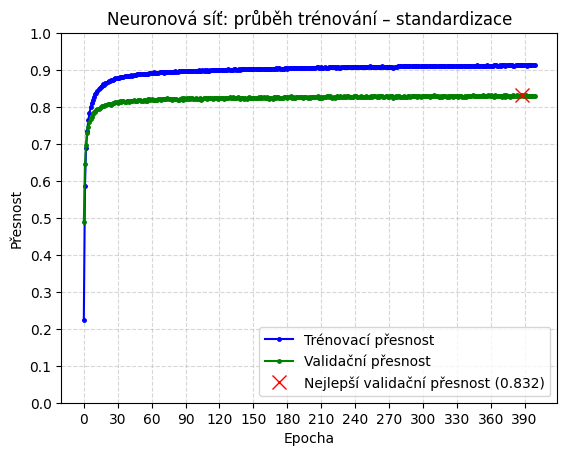

In [76]:
print_progress(epochs, train_acc, validation_acc, best_vacc, 'Neuronová síť', 'standardizace', save=True, save_path='images/NN_classic/feedforwardNN_standard_graph2.png')

In [25]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model_path = 'best_models/NN_classic/feedforwardNN_standard.pt'
model = FeedforwardNN_standard()
model.load_state_dict(torch.load(model_path))
model.eval()

FeedforwardNN_standard(
  (fc1): Linear(in_features=79, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=2048, bias=True)
  (drop2): Dropout(p=0.1, inplace=False)
  (fc6): Linear(in_features=2048, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  (fco): Linear(in_features=1024, out_features=1727, bias=True)
)

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [06:18<00:00,  4.74s/it]


Trénovací přesnost: 0.917


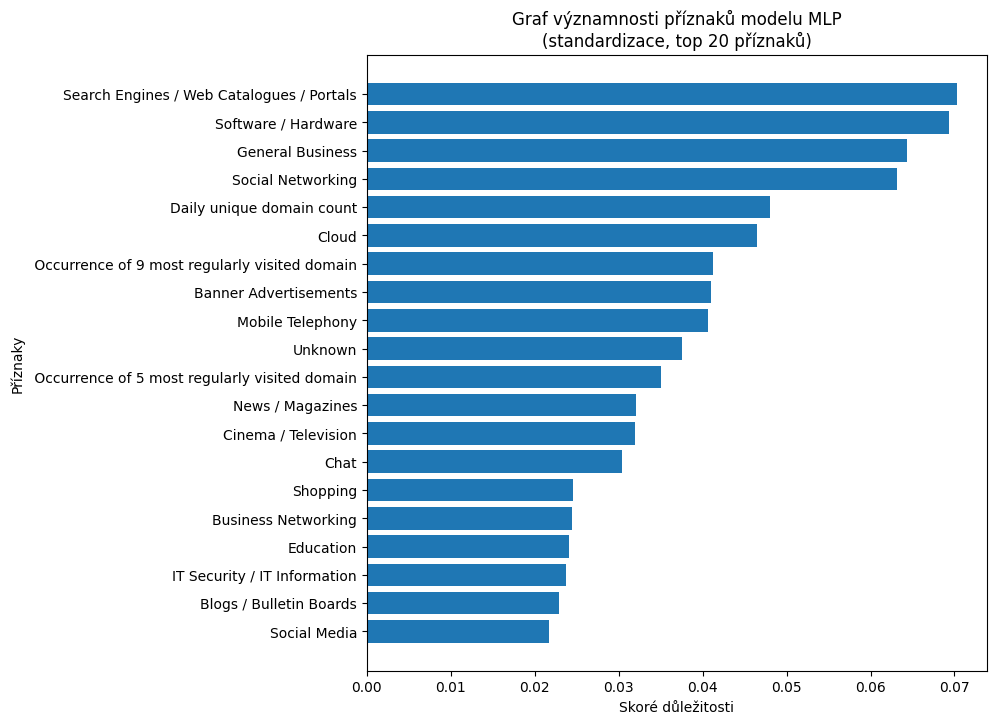

In [56]:
get_feature_importance_NN(Xtrain_standard, Ytrain_from_zero, model, 'MLP', 'standardizace', save=True, save_path='images/NN_classic/feedforwardNN_standard_features2.png')

Důležitost příznaků se u neuronových sítí opět počítá za pomoci `Permutation Feature Importance`. Nejlepší model vícevrstvého perceptronu ukazuje, že se model více soustředí na častěji se vyskytující příznaky (s nejvyšším objemem nenulových dat).

In [26]:
fina_eval_NN(model, len_train, train_loader, 'Trénovací')

(105777,)


100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:04<00:00, 11.03it/s]


Trénovací přesnost (accuracy): 0.91704

Trénovací preciznost (precision): 0.92122

Trénovací senzitivita (recall): 0.91170

Trénovací F1 skóre: 0.90967

Model predikoval 1661 (96.18 %) unikátních tříd. Neumí predikovat 66 (3.82 %) tříd.



In [28]:
fina_eval_NN(model, len_val, val_loader, 'Validační')

(23019,)


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:01<00:00, 122.50it/s]


Validační přesnost (accuracy): 0.83218

Validační preciznost (precision): 0.83578

Validační senzitivita (recall): 0.83034

Validační F1 skóre: 0.82785


Validační přesnost 83,2 % je zlepšením oproti modelu XGBoost a jde již o velice kvalitní výsledek. Deep learning metody tak dokázali překonat tradiční strojové modely.

__________
### Model IV - PCA

In [39]:
class FeedforwardNN_pca(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 2048)
        self.drop1 = nn.Dropout(p=0.1)
        self.fc6 = nn.Linear(2048, 1024)
        self.fco = nn.Linear(1024, 1727)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = F.selu(self.fc4(x))
        x = F.selu(self.fc5(x))
        x = self.drop1(x)
        x = F.selu(self.fc6(x))
        x = self.fco(x)
        return x

model = FeedforwardNN_pca()

In [40]:
len_train, len_val, train_loader, val_loader = prepare_loader(batch_size=2048, PCAA=True, n_comps=50)

Nastavení: {'batch_size': 2048, 'minmax': False, 'standard': False, 'PCAA': True, 'kwargs': {'n_comps': 50}}

===NumPy===
(105777, 50) (105777,)
(23019, 50) (23019,)

===Reshaped===
(105777, 1, 50) (105777,)
(23019, 1, 50) (23019,)

Počet bodů v trénovacím datasetu: 105777
Počet bodů ve validačním datasetu: 23019


In [69]:
dataiter = iter(train_loader)
data, labels = next(dataiter)

outputs = model(data)
print(data.shape, outputs.shape)

num_params = 0
for name, param in model.named_parameters():
    print(f"{name}\n# {param.numel()}")
    num_params += param.numel()
    
print(f"\nCelkový počet parametrů: {num_params}")

torch.Size([2048, 1, 50]) torch.Size([2048, 1727])
fc1.weight
# 6400
fc1.bias
# 128
fc2.weight
# 32768
fc2.bias
# 256
fc3.weight
# 131072
fc3.bias
# 512
fc4.weight
# 524288
fc4.bias
# 1024
fc5.weight
# 2097152
fc5.bias
# 2048
fc6.weight
# 2097152
fc6.bias
# 1024
fco.weight
# 1768448
fco.bias
# 1727

Celkový počet parametrů: 6663999


In [70]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [71]:
# .cuda() = přesun objektu z CPU na GPU
model.cuda();
epochs, train_acc, validation_acc, best_vacc = train_model(model, loss_fn, optimizer, len_train, len_val, train_loader, val_loader, 0, 400, 100, 'best_models/NN_classic/feedforwardNN_pca2.pt')
model.cpu();

EPOCHA 400:
TRÉNOVACÍ přesnost: 0.902, VALIDAČNÍ přesnost: 0.809
Ukládání nejlepšího modelu


In [72]:
best_vacc

tensor(0.8093)

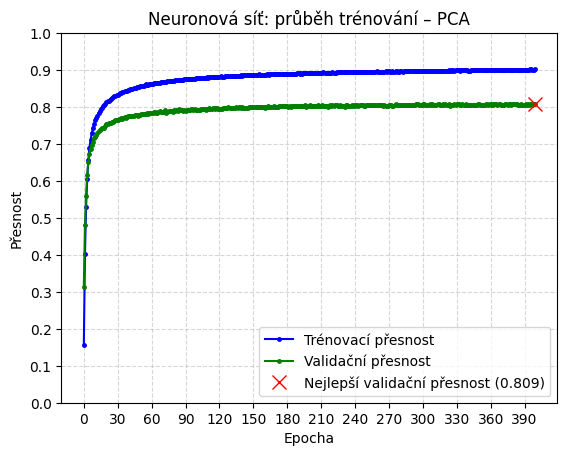

In [73]:
print_progress(epochs, train_acc, validation_acc, best_vacc, 'Neuronová síť', 'PCA', save=True, save_path='images/NN_classic/feedforwardNN_pca_graph2.png')

In [41]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model_path = 'best_models/NN_classic/feedforwardNN_pca.pt'
model = FeedforwardNN_pca()
model.load_state_dict(torch.load(model_path))
model.eval()

FeedforwardNN_pca(
  (fc1): Linear(in_features=50, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=2048, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (fc6): Linear(in_features=2048, out_features=1024, bias=True)
  (fco): Linear(in_features=1024, out_features=1727, bias=True)
)

In [42]:
fina_eval_NN(model, len_train, train_loader, 'Trénovací')

(105777,)


100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:04<00:00, 12.60it/s]



Trénovací přesnost (accuracy): 0.90532

Trénovací preciznost (precision): 0.91317

Trénovací senzitivita (recall): 0.89968

Trénovací F1 skóre: 0.89984

Model predikoval 1661 (96.18 %) unikátních tříd. Neumí predikovat 66 (3.82 %) tříd.



In [43]:
fina_eval_NN(model, len_val, val_loader, 'Validační')

(23019,)


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:01<00:00, 149.91it/s]


Validační přesnost (accuracy): 0.80933

Validační preciznost (precision): 0.82203

Validační senzitivita (recall): 0.80760

Validační F1 skóre: 0.80708


Celkové výsledky vícevrstvého perceptronu jsou velmi uspokojivé. Všechny modely dokázaly překonat hranici validační přesnosti 80 %, což je zejména u PCA pozoruhodný výsledek v porovnání s ostatními modely na PCA datech.

______
# 5) Konvoluční neuronová síť (CNN)

Konvoluční neuronová síť slouží jako alternativa k vícevrstvému perceptronu. Často se používá pro obrázková data nebo časové řady.

Osobně bych data v této práci řadil spiše mezi ta "obrázková", jelikož vzhledem k doménovým kategoriím, přítomných v příznacích vedle sebe, by mohly složit jistý obraz DNS otisku daného uživatele. Jelikož CNN slučuje postupně lokální struktury v datech do složitějších, tento DNS "obraz" by mohl být reálný.

Mezi přidané hyperparametry k ladění patří - _počet konvolučních vrstev_, _počet neuronů v konvolučních vrstvách_, _pooling_, _velikost jádra v konvolučních a pooling vrstvách_, _pooling_, _stride_, _padding_.

Zde je důležité zmínit, že pooling nepřinesl v trénování žádná zlepšení! Naopak výkonnost sítí lehce zhoršoval! Není tak přítomen v žádném z finálních modelů.

____
### Model I - zákadní data 

In [44]:
class CNN_classic(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, 3, padding=1)
        self.drop1 = nn.Dropout1d(p=0.1)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, 3, padding=1)
        # self.pool1 = nn.MaxPool1d(kernel_size=2, stride=1)
        self.conv4 = nn.Conv1d(128, 64, 3, padding=1)
        self.conv5 = nn.Conv1d(64, 32, 3, padding=1)
        self.fc1 = nn.Linear(32*79, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fco = nn.Linear(1024, 1727)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.drop1(x)
        x = F.selu(self.conv2(x))
        x = F.selu(self.conv3(x))
        # x = self.pool1(x)
        x = F.selu(self.conv4(x))
        x = F.selu(self.conv5(x))
        # print(x.shape)
        x = x.flatten(start_dim = 1)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = self.fco(x)
        return x

model = CNN_classic()

In [45]:
len_train, len_val, train_loader, val_loader = prepare_loader(batch_size=2048)

Nastavení: {'batch_size': 2048, 'minmax': False, 'standard': False, 'PCAA': False, 'kwargs': {}}

===NumPy===
(105777, 79) (105777,)
(23019, 79) (23019,)

===Reshaped===
(105777, 1, 79) (105777,)
(23019, 1, 79) (23019,)

Počet bodů v trénovacím datasetu: 105777
Počet bodů ve validačním datasetu: 23019


In [25]:
dataiter = iter(train_loader)
data, labels = next(dataiter)

outputs = model(data)
print(data.shape, outputs.shape)

num_params = 0
for name, param in model.named_parameters():
    print(f"{name}\n# {param.numel()}")
    num_params += param.numel()
    
print(f"\nCelkový počet parametrů: {num_params}")

torch.Size([2048, 1, 79]) torch.Size([2048, 1727])
conv1.weight
# 96
conv1.bias
# 32
conv2.weight
# 6144
conv2.bias
# 64
conv3.weight
# 24576
conv3.bias
# 128
conv4.weight
# 24576
conv4.bias
# 64
conv5.weight
# 6144
conv5.bias
# 32
fc1.weight
# 2588672
fc1.bias
# 1024
fc2.weight
# 1048576
fc2.bias
# 1024
fco.weight
# 1768448
fco.bias
# 1727

Celkový počet parametrů: 5471327


In [26]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [27]:
# .cuda() = přesun objektu z CPU na GPU
model.cuda();
epochs, train_acc, validation_acc, best_vacc = train_model(model, loss_fn, optimizer, len_train, len_val, train_loader, val_loader, 0, 400, 100, 'best_models/CNN/CNN_classic2.pt')
model.cpu();

EPOCHA 318:
TRÉNOVACÍ přesnost: 0.926, VALIDAČNÍ přesnost: 0.858
Žádné zlepšení v rámci této epochy. (101)
Předčasné zastavení


In [28]:
best_vacc

tensor(0.8605)

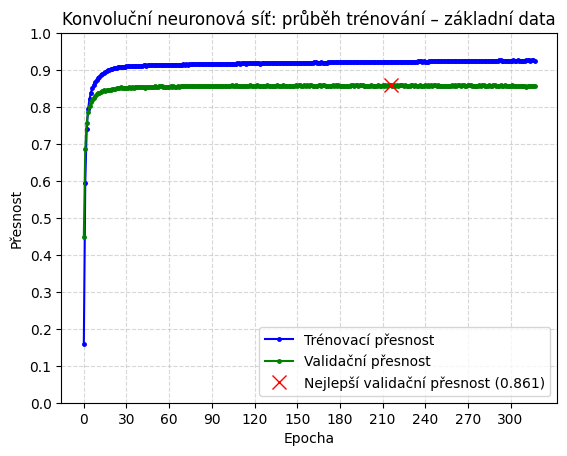

In [29]:
print_progress(epochs, train_acc, validation_acc, best_vacc, 'Konvoluční neuronová síť', 'základní data', save=True, save_path='images/CNN/CNN_classic_graph2.png')

In [46]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model_path = 'best_models/CNN/CNN_classic.pt'
model = CNN_classic()
model.load_state_dict(torch.load(model_path))
model.eval()

CNN_classic(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (drop1): Dropout1d(p=0.1, inplace=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=2528, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fco): Linear(in_features=1024, out_features=1727, bias=True)
)

In [47]:
fina_eval_NN(model, len_train, train_loader, 'Trénovací')

(105777,)


100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:09<00:00,  5.28it/s]


Trénovací přesnost (accuracy): 0.92339

Trénovací preciznost (precision): 0.93013

Trénovací senzitivita (recall): 0.91886

Trénovací F1 skóre: 0.91810

Model predikoval 1689 (97.80 %) unikátních tříd. Neumí predikovat 38 (2.20 %) tříd.



In [48]:
fina_eval_NN(model, len_val, val_loader, 'Validační')

(23019,)


100%|███████████████████████████████████████████████████████████████████████████████| 180/180 [00:01<00:00, 90.69it/s]


Validační přesnost (accuracy): 0.86055

Validační preciznost (precision): 0.86655

Validační senzitivita (recall): 0.85899

Validační F1 skóre: 0.85849


____
### Model II - minmax 

In [49]:
class CNN_minmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, 2, padding=1)
        self.drop1 = nn.Dropout1d(p=0.1)
        self.conv2 = nn.Conv1d(16, 32, 2, padding=1)
        # self.pool1 = nn.MaxPool1d(kernel_size=2, stride=1)
        self.conv3 = nn.Conv1d(32, 64, 2, padding=1)
        self.conv4 = nn.Conv1d(64, 128, 2, padding=1)
        self.conv5 = nn.Conv1d(128, 64, 2, padding=1)
        self.fc1 = nn.Linear(64*84, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024,1024)
        self.fco = nn.Linear(1024, 1727)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.drop1(x)
        x = F.selu(self.conv2(x))
        # x = self.pool1(x)
        x = F.selu(self.conv3(x))
        x = F.selu(self.conv4(x))
        x = F.selu(self.conv5(x))
        # print(x.shape)
        x = x.flatten(start_dim = 1)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.fco(x)
        return x

model = CNN_minmax()

In [50]:
len_train, len_val, train_loader, val_loader = prepare_loader(batch_size=2048, minmax=True)

Nastavení: {'batch_size': 2048, 'minmax': True, 'standard': False, 'PCAA': False, 'kwargs': {}}

===NumPy===
(105777, 79) (105777,)
(23019, 79) (23019,)

===Reshaped===
(105777, 1, 79) (105777,)
(23019, 1, 79) (23019,)

Počet bodů v trénovacím datasetu: 105777
Počet bodů ve validačním datasetu: 23019


In [50]:
dataiter = iter(train_loader)
data, labels = next(dataiter)

outputs = model(data)
print(data.shape, outputs.shape)

num_params = 0
for name, param in model.named_parameters():
    print(f"{name}\n# {param.numel()}")
    num_params += param.numel()
    
print(f"\nCelkový počet parametrů: {num_params}")

torch.Size([2048, 1, 79]) torch.Size([2048, 1727])
conv1.weight
# 32
conv1.bias
# 16
conv2.weight
# 1024
conv2.bias
# 32
conv3.weight
# 4096
conv3.bias
# 64
conv4.weight
# 16384
conv4.bias
# 128
conv5.weight
# 16384
conv5.bias
# 64
fc1.weight
# 11010048
fc1.bias
# 2048
fc2.weight
# 2097152
fc2.bias
# 1024
fc3.weight
# 1048576
fc3.bias
# 1024
fco.weight
# 1768448
fco.bias
# 1727

Celkový počet parametrů: 15968271


In [51]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [52]:
# .cuda() = přesun objektu z CPU na GPU
model.cuda();
epochs, train_acc, validation_acc, best_vacc = train_model(model, loss_fn, optimizer, len_train, len_val, train_loader, val_loader, 0, 400, 100, 'best_models/CNN/CNN_minmax2.pt')
model.cpu();

EPOCHA 400:
TRÉNOVACÍ přesnost: 0.928, VALIDAČNÍ přesnost: 0.866
Žádné zlepšení v rámci této epochy. (41)


In [53]:
best_vacc

tensor(0.8674)

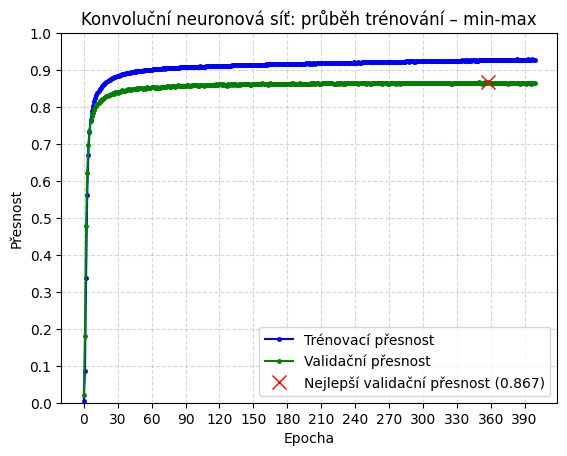

In [54]:
print_progress(epochs, train_acc, validation_acc, best_vacc, 'Konvoluční neuronová síť', 'min-max', save=True, save_path='images/CNN/CNN_minmax_graph2.png')

In [51]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model_path = 'best_models/CNN/CNN_minmax.pt'
model = CNN_minmax()
model.load_state_dict(torch.load(model_path))
model.eval()

CNN_minmax(
  (conv1): Conv1d(1, 16, kernel_size=(2,), stride=(1,), padding=(1,))
  (drop1): Dropout1d(p=0.1, inplace=False)
  (conv2): Conv1d(16, 32, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 128, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv5): Conv1d(128, 64, kernel_size=(2,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=5376, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fco): Linear(in_features=1024, out_features=1727, bias=True)
)

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [18:49<00:00, 14.12s/it]


Trénovací přesnost: 0.931


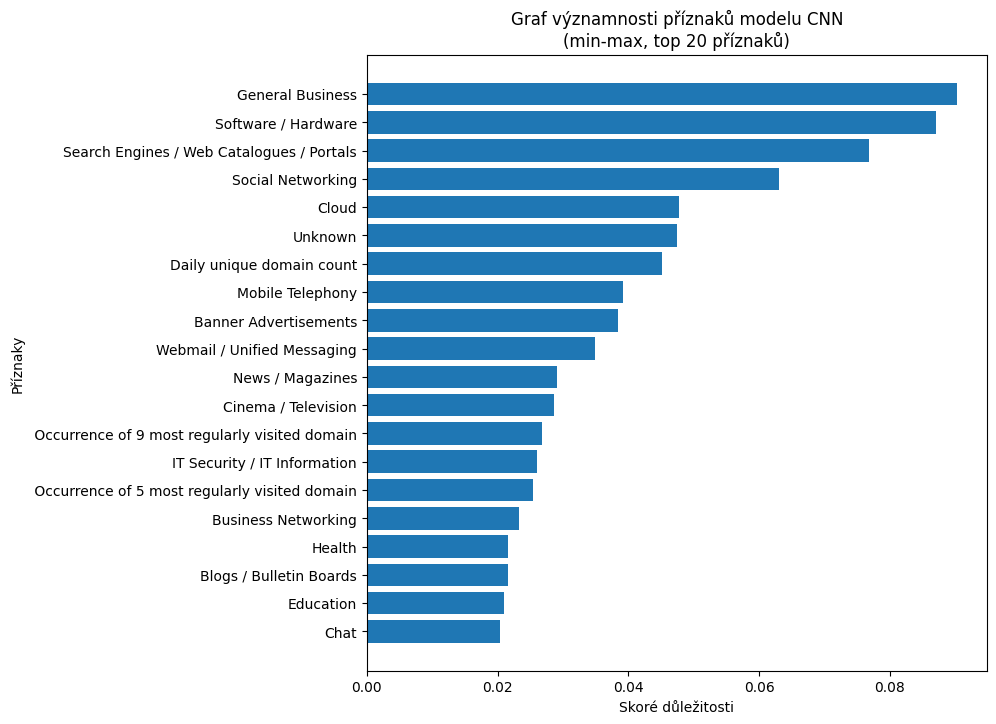

In [59]:
get_feature_importance_NN(Xtrain_minmax, Ytrain_from_zero, model, 'CNN', 'min-max', save=True, save_path='images/CNN/CNN_minmax_features2.png')

Důležitost příznaků opět pomocí `Permutation Feature Importance`. Podobně jako u MLP, model se více soustředí na nejčetnější příznaky.

In [52]:
fina_eval_NN(model, len_train, train_loader, 'Trénovací')

(105777,)


100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:13<00:00,  3.97it/s]



Trénovací přesnost (accuracy): 0.93067

Trénovací preciznost (precision): 0.93714

Trénovací senzitivita (recall): 0.92606

Trénovací F1 skóre: 0.92534

Model predikoval 1694 (98.09 %) unikátních tříd. Neumí predikovat 33 (1.91 %) tříd.



In [53]:
fina_eval_NN(model, len_val, val_loader, 'Validační')

(23019,)


100%|███████████████████████████████████████████████████████████████████████████████| 180/180 [00:02<00:00, 60.36it/s]


Validační přesnost (accuracy): 0.86741

Validační preciznost (precision): 0.87083

Validační senzitivita (recall): 0.86584

Validační F1 skóre: 0.86443


____
### Model III - standardizace 

In [54]:
class CNN_standard(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, 3, padding=1)
        self.drop1 = nn.Dropout1d(p=0.1)
        self.conv2 = nn.Conv1d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv1d(64, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*79, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fco = nn.Linear(1024, 1727)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.drop1(x)
        x = F.selu(self.conv2(x))
        x = F.selu(self.conv3(x))
        x = F.selu(self.conv4(x))
        x = F.selu(self.conv5(x))
        # print(x.shape)
        x = x.flatten(start_dim = 1)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.fco(x)
        return x

model = CNN_standard()

In [55]:
len_train, len_val, train_loader, val_loader = prepare_loader(batch_size=2048, standard=True)

Nastavení: {'batch_size': 2048, 'minmax': False, 'standard': True, 'PCAA': False, 'kwargs': {}}

===NumPy===
(105777, 79) (105777,)
(23019, 79) (23019,)

===Reshaped===
(105777, 1, 79) (105777,)
(23019, 1, 79) (23019,)

Počet bodů v trénovacím datasetu: 105777
Počet bodů ve validačním datasetu: 23019


In [81]:
dataiter = iter(train_loader)
data, labels = next(dataiter)

outputs = model(data)
print(data.shape, outputs.shape)

num_params = 0
for name, param in model.named_parameters():
    print(f"{name}\n# {param.numel()}")
    num_params += param.numel()
    
print(f"\nCelkový počet parametrů: {num_params}")

torch.Size([2048, 1, 79]) torch.Size([2048, 1727])
conv1.weight
# 48
conv1.bias
# 16
conv2.weight
# 1536
conv2.bias
# 32
conv3.weight
# 6144
conv3.bias
# 64
conv4.weight
# 12288
conv4.bias
# 64
conv5.weight
# 12288
conv5.bias
# 64
fc1.weight
# 5177344
fc1.bias
# 1024
fc2.weight
# 1048576
fc2.bias
# 1024
fc3.weight
# 1048576
fc3.bias
# 1024
fco.weight
# 1768448
fco.bias
# 1727

Celkový počet parametrů: 9080287


In [82]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [83]:
# .cuda() = přesun objektu z CPU na GPU
model.cuda();
epochs, train_acc, validation_acc, best_vacc = train_model(model, loss_fn, optimizer, len_train, len_val, train_loader, val_loader, 0, 400, 100, 'best_models/CNN/CNN_standard2.pt')
model.cpu();

EPOCHA 284:
TRÉNOVACÍ přesnost: 0.916, VALIDAČNÍ přesnost: 0.846
Žádné zlepšení v rámci této epochy. (101)
Předčasné zastavení


In [84]:
best_vacc

tensor(0.8491)

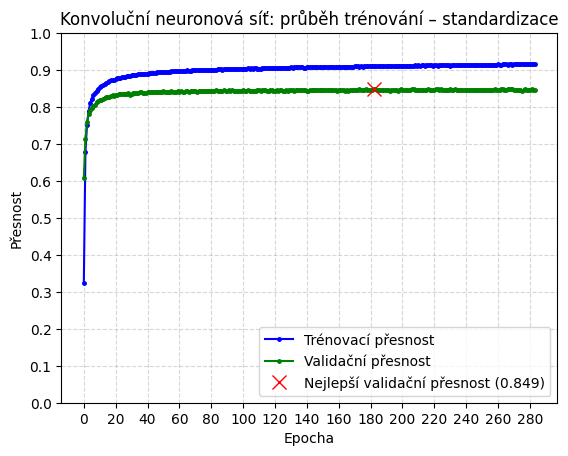

In [85]:
print_progress(epochs, train_acc, validation_acc, best_vacc, 'Konvoluční neuronová síť', 'standardizace', save=True, save_path='images/CNN/CNN_standard_graph2.png')

In [56]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model_path = 'best_models/CNN/CNN_standard.pt'
model = CNN_standard()
model.load_state_dict(torch.load(model_path))
model.eval()

CNN_standard(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (drop1): Dropout1d(p=0.1, inplace=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=5056, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fco): Linear(in_features=1024, out_features=1727, bias=True)
)

In [57]:
fina_eval_NN(model, len_train, train_loader, 'Trénovací')

(105777,)


100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:08<00:00,  5.81it/s]


Trénovací přesnost (accuracy): 0.91474

Trénovací preciznost (precision): 0.91668

Trénovací senzitivita (recall): 0.90932

Trénovací F1 skóre: 0.90849

Model predikoval 1657 (95.95 %) unikátních tříd. Neumí predikovat 70 (4.05 %) tříd.



In [58]:
fina_eval_NN(model, len_val, val_loader, 'Validační')

(23019,)


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:01<00:00, 104.19it/s]



Validační přesnost (accuracy): 0.84908

Validační preciznost (precision): 0.85611

Validační senzitivita (recall): 0.84735

Validační F1 skóre: 0.84622


____
### Model IV - PCA 

In [59]:
class CNN_pca(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, 2, padding=1)
        self.drop1 = nn.Dropout1d(p=0.1)
        self.conv2 = nn.Conv1d(32, 64, 2, padding=1)
        self.conv3 = nn.Conv1d(64, 128, 2, padding=1)
        self.conv4 = nn.Conv1d(128, 64, 2, padding=1)
        self.fc1 = nn.Linear(64*54, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fco = nn.Linear(1024, 1727)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.drop1(x)
        x = F.selu(self.conv2(x))
        x = F.selu(self.conv3(x))
        x = F.selu(self.conv4(x))
        # print(x.shape)
        x = x.flatten(start_dim = 1)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.fco(x)
        return x

model = CNN_pca()

In [60]:
len_train, len_val, train_loader, val_loader = prepare_loader(batch_size=2048, PCAA=True, n_comps=50)

Nastavení: {'batch_size': 2048, 'minmax': False, 'standard': False, 'PCAA': True, 'kwargs': {'n_comps': 50}}

===NumPy===
(105777, 50) (105777,)
(23019, 50) (23019,)

===Reshaped===
(105777, 1, 50) (105777,)
(23019, 1, 50) (23019,)

Počet bodů v trénovacím datasetu: 105777
Počet bodů ve validačním datasetu: 23019


In [129]:
dataiter = iter(train_loader)
data, labels = next(dataiter)

outputs = model(data)
print(data.shape, outputs.shape)

num_params = 0
for name, param in model.named_parameters():
    print(f"{name}\n# {param.numel()}")
    num_params += param.numel()
    
print(f"\nCelkový počet parametrů: {num_params}")

torch.Size([2048, 1, 50]) torch.Size([2048, 1727])
conv1.weight
# 64
conv1.bias
# 32
conv2.weight
# 4096
conv2.bias
# 64
conv3.weight
# 16384
conv3.bias
# 128
conv4.weight
# 16384
conv4.bias
# 64
fc1.weight
# 7077888
fc1.bias
# 2048
fc2.weight
# 2097152
fc2.bias
# 1024
fc3.weight
# 1048576
fc3.bias
# 1024
fco.weight
# 1768448
fco.bias
# 1727

Celkový počet parametrů: 12035103


In [130]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [131]:
# .cuda() = přesun objektu z CPU na GPU
model.cuda();
epochs, train_acc, validation_acc, best_vacc = train_model(model, loss_fn, optimizer, len_train, len_val, train_loader, val_loader, 0,400, 100, 'best_models/CNN/CNN_pca2.pt')
model.cpu();

EPOCHA 254:
TRÉNOVACÍ přesnost: 0.900, VALIDAČNÍ přesnost: 0.789
Žádné zlepšení v rámci této epochy. (101)
Předčasné zastavení


In [132]:
best_vacc

tensor(0.7906)

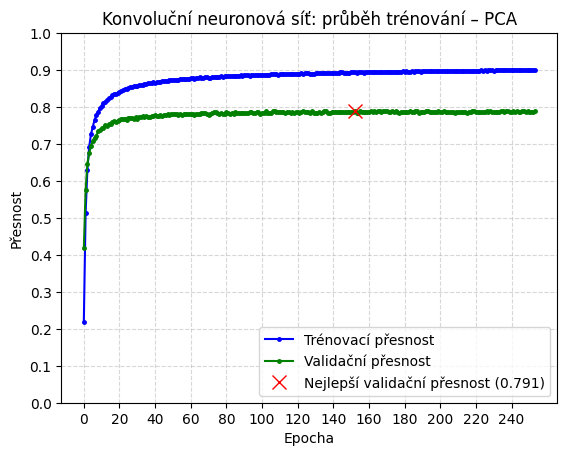

In [133]:
print_progress(epochs, train_acc, validation_acc, best_vacc, 'Konvoluční neuronová síť', 'PCA', save=True, save_path='images/CNN/CNN_pca_graph2.png')

In [61]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path = 'best_models/CNN/CNN_pca.pt'
model = CNN_pca()
model.load_state_dict(torch.load(model_path))
model.eval()

CNN_pca(
  (conv1): Conv1d(1, 32, kernel_size=(2,), stride=(1,), padding=(1,))
  (drop1): Dropout1d(p=0.1, inplace=False)
  (conv2): Conv1d(32, 64, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv4): Conv1d(128, 64, kernel_size=(2,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=3456, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fco): Linear(in_features=1024, out_features=1727, bias=True)
)

In [62]:
fina_eval_NN(model, len_train, train_loader, 'Trénovací')

(105777,)


100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:09<00:00,  5.42it/s]



Trénovací přesnost (accuracy): 0.89861

Trénovací preciznost (precision): 0.90118

Trénovací senzitivita (recall): 0.89260

Trénovací F1 skóre: 0.89192

Model predikoval 1638 (94.85 %) unikátních tříd. Neumí predikovat 89 (5.15 %) tříd.



In [63]:
fina_eval_NN(model, len_val, val_loader, 'Validační')

(23019,)


100%|███████████████████████████████████████████████████████████████████████████████| 180/180 [00:02<00:00, 82.93it/s]


Validační přesnost (accuracy): 0.79061

Validační preciznost (precision): 0.80221

Validační senzitivita (recall): 0.78888

Validační F1 skóre: 0.78721


Konvoluční neuronové sítě znovu přinesly zlepšení ve výsledcích. Kombinace **CNN + min-max** přinesla výslednou validační přesnost **86,7 %**. Překročení hranice 85 % již ukazuje na vysokou kvalitu modelu. Konvoluční vrstvy tak byly velkým způsobem přínosné.

Výsledky PCA ovšem potkalo zhoršení oproti vícevrstvému perceptronu. Celkově jde také o nejhorší výsledek ze všech neuronových sítí. I když PCA data nedosahovala takových kvalit jako běžné normalizační metody, výsledek validační přesnosti téměř 81 % není špatný. V případě nutnosti pracovat s redukovanými daty je tak zachována velká většina kvality predikce. Je otázkou, zda by jine metody redukce dimenze fungovaly lépe.

____
# Testovací přesnost

Na závěr je třeba vytvořit odhad přesnosti nejlepšího modelu - **CNN + min-max** - na neznámých datech. K tomu slouží testovací množina. Správně by testovací přesnost neměla být (příliš) odlišná od validační přesnosti. Pokud by se tak stalo, model by nebyl dostatečně kvalitní pro neznámá data (nebo by to také znamenalo špatné rozdělení dat mezi trénovací, validační a testovací množiny).

In [64]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model_path = 'best_models/CNN/CNN_minmax.pt'
model = CNN_minmax()
model.load_state_dict(torch.load(model_path))
model.eval()

CNN_minmax(
  (conv1): Conv1d(1, 16, kernel_size=(2,), stride=(1,), padding=(1,))
  (drop1): Dropout1d(p=0.1, inplace=False)
  (conv2): Conv1d(16, 32, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 128, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv5): Conv1d(128, 64, kernel_size=(2,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=5376, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fco): Linear(in_features=1024, out_features=1727, bias=True)
)

In [65]:
Xtest = pd.read_csv('train_test_data/test.csv', sep=';')
Xtest = Xtest.sample(frac=1).reset_index(drop=True)
Ytest = Xtest['IP ID']
Xtest = Xtest.drop('IP ID', axis=1)
print(Xtest.shape, Ytest.shape)
Ytest_from_zero = []
for idd in Ytest:
    Ytest_from_zero.append(mapping_id_to_int[idd])

(23020, 79) (23020,)


In [66]:
Xtest_minmax = min_max_scaler.transform(Xtest)
Xtest_minmax = pd.DataFrame(Xtest_minmax, columns=Xtrain.columns)

Xtest_final = Xtest_minmax.to_numpy()
Ytest_mod = np.asarray(Ytest_from_zero, dtype=np.float32)

print('===NumPy===')
print(Xtest_final.shape, Ytest_mod.shape)

Xtest_final = Xtest_final.reshape(-1,1,79)

print('\n===Reshaped===')
print(Xtest_final.shape, Ytest_mod.shape)

Xtest_final_tensor = torch.tensor(Xtest_final, dtype = torch.float)
Ytest_final_tensor = torch.tensor(Ytest_mod, dtype=torch.long)


test_final_dataset = torch.utils.data.TensorDataset(Xtest_final_tensor, Ytest_final_tensor)
test_final_loader = torch.utils.data.DataLoader(test_final_dataset, batch_size=2048, shuffle=False)

print(f'Počet bodů v testovacím datasetu: {len(test_final_dataset)}')

===NumPy===
(23020, 79) (23020,)

===Reshaped===
(23020, 1, 79) (23020,)
Počet bodů v testovacím datasetu: 23020


In [67]:
len_train_final, len_val_final, train_loader_final, val_loader_final = prepare_loader(batch_size=2048, minmax=True)

Nastavení: {'batch_size': 2048, 'minmax': True, 'standard': False, 'PCAA': False, 'kwargs': {}}

===NumPy===
(105777, 79) (105777,)
(23019, 79) (23019,)

===Reshaped===
(105777, 1, 79) (105777,)
(23019, 1, 79) (23019,)

Počet bodů v trénovacím datasetu: 105777
Počet bodů ve validačním datasetu: 23019


Pro celkový souhrn budou zobrazeny výsledky na všech 3 datových množinách. Smysl zobrazení preciznosti, senzitivity a F1 skóre je takový, aby "kontrolovaly" metriku přesnosti. V případě, že by jedna z ostatních metrik totiž byla výrazně odlišná od ostatních, znamenalo by to jistý vykřičník pro obecnou kvalitu modelu. Pokud jsou metriky na podobných úrovních, naznačuje to dobrou generalizační schopnost.  

In [68]:
fina_eval_NN(model, len_train_final, train_loader_final, 'Trénovací')

(105777,)


100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:12<00:00,  4.05it/s]



Trénovací přesnost (accuracy): 0.93067

Trénovací preciznost (precision): 0.93714

Trénovací senzitivita (recall): 0.92606

Trénovací F1 skóre: 0.92534

Model predikoval 1694 (98.09 %) unikátních tříd. Neumí predikovat 33 (1.91 %) tříd.



Model se nenaučil predikovat 33 tříd. To sice není tak dobrý výsledek jako u modelů XGBoostu, nicméně dosahovaná validační přesnost tento nedostatek převyšuje.

In [69]:
fina_eval_NN(model, len_val_final, val_loader_final, 'Validační')

(23019,)


100%|███████████████████████████████████████████████████████████████████████████████| 180/180 [00:02<00:00, 61.76it/s]


Validační přesnost (accuracy): 0.86741

Validační preciznost (precision): 0.87083

Validační senzitivita (recall): 0.86584

Validační F1 skóre: 0.86443


In [72]:
fina_eval_NN(model, len(test_final_dataset), test_final_loader, 'Testovací')

(23020,)


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.20it/s]


Testovací přesnost (accuracy): 0.86620

Testovací preciznost (precision): 0.86929

Testovací senzitivita (recall): 0.86426

Testovací F1 skóre: 0.86278


Z náhledu do výsledků získaných na testovacích datech se tedy závěrem k praktické části dá tvrdit, že se povedlo úspěšně získat model, který dokáže s vysokou přesností indetifikovat uživatele na základě jeho DNS otisku. 

### Výsledný model konvoluční neuronové sítě, natrénovaný na datech normalizovaných metodou min-max, dokáže úspěšně identifikovat uživatele v dané síti na základě jeho DNS otisku s úspěšností 86,6 %.